In [143]:
import numpy as np
import uproot
import vector
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import torch
from numpy.random import seed
seed_value = 420 
seed(seed_value)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,classification_report,roc_auc_score,roc_curve,recall_score, average_precision_score
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import roc_curve
import itertools
from sklearn.inspection import permutation_importance
import boost_histogram as bh
from sklearn.model_selection import KFold

#directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

## Functions

In [ ]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts() / norm_factor, hist.axes[0].edges, ax=axes, label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, label=data_label[i], histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[ak.num(particles)>=i])!=0:
        particles_i = particles[ak.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None

def duplicate_cleaner(ids, truth):
    reshaped_ids = ak.unflatten(ak.ravel(ak.Array(ids['id'])),ak.num(ak.Array(ids['id'])))
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(reshaped_ids)])
    has_repeats = ak.num(deduped_id_pairs) != ak.num(reshaped_ids)
    one_repeat = ak.num(deduped_id_pairs) == ak.num(reshaped_ids) - 1
    more_repeats = ak.num(deduped_id_pairs) < (ak.num(reshaped_ids) - 1)

    duplicate_truth_1 = truth[one_repeat]
    duplicate_ids_1 = ids[one_repeat]

    more_duplicate_truth = truth[more_repeats]
    more_duplicate_ids = ids[more_repeats]

    id_pairs = ids[~has_repeats]
    return id_pairs, (duplicate_truth_1, duplicate_ids_1), (more_duplicate_truth, more_duplicate_ids)

j = 0
def duplicate_matcher(id_pairs, truth, i):
    repeat_ids = ak.unflatten(ak.ravel(ak.Array(id_pairs['id'])),ak.num(ak.Array(id_pairs['id'])))
    repeat_i = ak.num(repeat_ids[repeat_ids==i], axis=1)==2

    truth_i = truth[repeat_i]
    id_pairs_i = id_pairs[repeat_i]

    valid_id_particles = id_pairs_i[id_pairs_i['id']!=i]
    valid_id_particles = valid_id_particles[ak.num(valid_id_particles, axis=2)!=0]

    repeat_recos = id_pairs_i[id_pairs_i['id']==i]
    repeat_recos = repeat_recos[ak.num(repeat_recos, axis=2)!=0]

    duplicate_deltars = ak.unflatten(ak.ravel(repeat_recos['reco'].deltaR(truth_i[:,i-1])),2)
    min_dupdeltars = ak.unflatten(ak.min(duplicate_deltars, axis=1),1)

    matched_recos = repeat_recos[duplicate_deltars==min_dupdeltars]
    unmatched_recos = ak.unflatten(ak.ravel(repeat_recos['reco'][duplicate_deltars!=min_dupdeltars]),1)

    valid_id_particles = ak.concatenate((valid_id_particles, matched_recos), axis=1)
    possible_truth = ak.concatenate((truth_i[:,0:i-1],truth_i[:,i:len(truth[0])]), axis=1)

    id = np.tile(np.hstack((np.arange(1,i),np.arange(i+1,len(possible_truth[0])+2))), (len(possible_truth),1))
    pairs_2d = ak.cartesian({'reco':unmatched_recos,'truth':possible_truth})
    id_pairs_2d = ak.cartesian({'reco':unmatched_recos,'id':id})
    pairs_3d = ak.unflatten(pairs_2d, len(possible_truth[0]), axis=1)
    id_pairs_3d = ak.unflatten(id_pairs_2d, len(possible_truth[0]), axis=1)

    deltars = ak.unflatten(ak.ravel(pairs_3d['reco'].deltaR(pairs_3d['truth'])),len(truth[0])-1)
    min_deltars = ak.unflatten(np.min(deltars, axis=1),1)

    id_pairs_3d = id_pairs_3d[ak.unflatten(deltars == min_deltars,1)]
    id_pairs_3d = id_pairs_3d[min_deltars<0.4]
    add_match = valid_id_particles[ak.num(id_pairs_3d)!=0]

    valid_id_events = valid_id_particles[ak.num(id_pairs_3d)==0]
    pairs_to_concatenate = [valid_id_events]

    id_pairs_3d = id_pairs_3d[ak.num(id_pairs_3d)!=0]
    additional_matches = ak.concatenate((id_pairs_3d, add_match), axis=1)

    reshaped_ids = ak.unflatten(ak.ravel(ak.Array(additional_matches['id'])),ak.num(ak.Array(additional_matches['id'])))
    deduped_id_pairs = ak.Array([list(dict.fromkeys(row)) for row in ak.to_list(reshaped_ids)])
    if len(reshaped_ids) != 0:
        has_repeats = ak.num(deduped_id_pairs) != ak.num(reshaped_ids)
        pairs_to_concatenate.append(id_pairs_3d[has_repeats])
        pairs_to_concatenate.append(additional_matches[~has_repeats])
        print(len(id_pairs_3d[has_repeats]))
    else:
        pairs_to_concatenate.append(id_pairs_3d)
    
    clean_id_pairs = ak.concatenate(pairs_to_concatenate)
    repeat_ids = ak.unflatten(ak.ravel(id_pairs['id']),ak.num(id_pairs['id']))
    return clean_id_pairs


def truth_matching(reco, truth):
    id = np.tile(np.arange(1,len(truth[0])+1), (len(truth),1))
    pairs_2d = ak.cartesian({'reco':reco,'truth':truth})
    id_pairs_2d = ak.cartesian({'reco':reco,'id':id})
    pairs_3d = ak.unflatten(pairs_2d, len(truth[0]), axis=1)
    id_pairs_3d = ak.unflatten(id_pairs_2d, len(truth[0]), axis=1)

    deltars = pairs_3d['reco'].deltaR(pairs_3d['truth'])
    min_deltars = np.min(deltars, axis=2)
    id_pairs_3d = id_pairs_3d[(deltars == min_deltars)]
    id_pairs_3d = id_pairs_3d[min_deltars<0.4]

    id_pairs_3d, (duplicate_truths, duplicate_id_pairs), (more_duplicate_truth, more_duplicate_ids)  = duplicate_cleaner(id_pairs_3d, truth)
    print(len(id_pairs_3d), len(duplicate_truths))
    clean_events = [id_pairs_3d]
    i_range = np.arange(1,len(truth[0])+1)
    for i in i_range:
        clean_events.append(duplicate_matcher(duplicate_id_pairs, duplicate_truths, i))
    clean_events = ak.concatenate(clean_events)
    print(len(clean_events))
    
    return clean_events

class Classifier_MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, dropout_rate, out_dim):
        super().__init__()
        self.h1 = nn.Linear(in_dim, hidden_dim1)
        self.h2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.h3 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_dim2, out_dim)
        self.out_dim = out_dim        

    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.h3(x)
        x = self.out(x)
        return x, F.softmax(x,dim=1)

    def fit(self, train_loader, valid_loader, optimiser, verbose=True):
        _results = []  # Store training and validation metrics
        for epoch in range(epochs):
            # Training loop
            self.train()  # Set the model to training mode
            with torch.enable_grad():
                train_loss = 0.0
                for batch, (x_train_batch, y_train_batch) in enumerate(train_loader):
                    self.zero_grad()  # Zero gradients
                    out, prob = self(x_train_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_train_batch)  # Compute loss
                    loss.backward()  # Backpropagation
                    optimiser.step()  # Update weights
                    train_loss += loss.item() * x_train_batch.size(0)

            train_loss /= len(train_loader.dataset)  # Average training loss

            if verbose:
                print("Epoch: {}, Train Loss: {:4f}".format(epoch+1, train_loss))

            # Validation loop
            self.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct = 0
                valid_loss = 0.0

                for i, (x_valid_batch, y_valid_batch) in enumerate(valid_loader):
                    out, prob = self(x_valid_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_valid_batch)  # Compute loss
                    valid_loss += loss.item() * x_valid_batch.size(0)
                    preds = prob.argmax(dim=1, keepdim=True)  # Get predictions
                    correct += preds.eq(y_valid_batch.view_as(preds)).sum().item()  # Count correct

                valid_loss /= len(valid_loader.dataset)  # Average validation loss
                accuracy = correct / len(valid_loader.dataset)  # Calculate accuracy

            if verbose:
                print("Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(valid_loss, accuracy))

            # Store results
            _results.append([epoch, train_loss, valid_loss, accuracy])

        results = np.array(_results)  # Make array of results
        print("Finished Training")
        print("Final validation error: ", 100.0 * (1 - accuracy), "%")

    def score(self,X_test_tensor,y_test_tensor):
        self.eval()
        with torch.no_grad():
            if isinstance(X_test_tensor, np.ndarray) or isinstance(y_test_tensor, np.ndarray):
                if isinstance(X_test_tensor, np.ndarray):
                    X_test_tensor = torch.from_numpy(X_test_tensor).float()
                if isinstance(y_test_tensor, np.ndarray):
                    y_test_tensor = torch.from_numpy(y_test_tensor).long()
                out, prob = self(X_test_tensor)
                y_pred_NN_partonic = (prob.cpu().detach().numpy().argmax(axis=1))
                return accuracy_score(y_test_tensor,y_pred_NN_partonic)
    

def AMS(TPR,FPR,b_r):
    AMS = np.sqrt(2*(TPR+FPR+b_r)*np.log(1+TPR/(FPR+b_r))-TPR)
    return AMS
b_reg = 0.001

def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        if hasattr(clf, "predict_proba"): # if predict_proba function exists
            d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
            d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        else: # predict_proba function doesn't exist
            X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
            y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
            X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
            d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
            d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    ax[1,1].hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    ax[1,1].hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    ax[1,1].errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='blue', label='Background (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    ax[1,1].errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='orange', label='Signal (test)' ) # Signal (test)
    
    ax[1,1].set_xlabel(xlabel) # write x-axis label
    ax[1,1].set_ylabel("Arbitrary units") # write y-axis label
    ax[1,1].legend() # add legend

## Extracting Data

In [145]:
tree4 = uproot.open(directory + "4tops_withtruth_oct24.root")
events_4t_jets = tree4["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.Mass','Jet.BTag'])
events_4t_electrons = tree4["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi'])
events_4t_muons = tree4["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi'])
events_4t_neutrinos = tree4["Delphes;1"]['MissingET'].arrays(['MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
events_4t_truth = tree4['Delphes;1']['Particle'].arrays(['Particle.PID','Particle.Status','Particle.Mass','Particle.PT','Particle.Eta','Particle.Phi'])
events_4t_truth = events_4t_truth[(events_4t_truth['Particle.Status']==23)]

events_4t_electrons['Electron.Mass'] = np.ones_like(events_4t_electrons['Electron.PT']) * 0.511E-3
events_4t_muons['Muon.Mass'] = np.ones_like(events_4t_muons['Muon.PT']) * 105.7E-3

jets_pt_4t = events_4t_jets['Jet.PT'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]
jets_eta_4t = events_4t_jets['Jet.Eta'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]
jets_phi_4t = events_4t_jets['Jet.Phi'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]
jets_mass_4t = events_4t_jets['Jet.Mass'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]

electrons_pt_4t = events_4t_electrons['Electron.PT'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]
electrons_eta_4t = events_4t_electrons['Electron.Eta'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]
electrons_phi_4t = events_4t_electrons['Electron.Phi'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]
electrons_mass_4t = events_4t_electrons['Electron.Mass'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]

muons_pt_4t = events_4t_muons['Muon.PT'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]
muons_eta_4t = events_4t_muons['Muon.Eta'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]
muons_phi_4t = events_4t_muons['Muon.Phi'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]
muons_mass_4t = events_4t_muons['Muon.Mass'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]

reco_pt_4t = ak.concatenate((jets_pt_4t,electrons_pt_4t,muons_pt_4t), axis=1)
reco_eta_4t = ak.concatenate((jets_eta_4t,electrons_eta_4t,muons_eta_4t), axis=1)
reco_phi_4t = ak.concatenate((jets_phi_4t,electrons_phi_4t,muons_phi_4t), axis=1)
reco_mass_4t = ak.concatenate((jets_mass_4t,electrons_mass_4t,muons_mass_4t), axis=1)

truth_pt_4t = events_4t_truth['Particle.PT']
truth_eta_4t = events_4t_truth['Particle.Eta']
truth_phi_4t = events_4t_truth['Particle.Phi']
truth_mass_4t = events_4t_truth['Particle.Mass']

reco_4t = vector.zip({'pt':reco_pt_4t,'eta':reco_eta_4t,'phi':reco_phi_4t,'mass':reco_mass_4t})
truth_4t = vector.zip({'pt':truth_pt_4t,'eta':truth_eta_4t,'phi':truth_phi_4t,'mass':truth_mass_4t})

### Partonic arrays

In [146]:
reco_4t_test = reco_4t[(ak.num(reco_4t)!=0)&(ak.num(truth_4t)!=0)]
truth_4t_test = truth_4t[(ak.num(reco_4t)!=0)&(ak.num(truth_4t)!=0)]

truth_4t_12 = truth_4t[ak.num(truth_4t)==12]
reco_4t_12 = reco_4t[ak.num(truth_4t)==12]

truth_4t_13 = truth_4t[ak.num(truth_4t)==13]
truth_4t_13 = truth_4t_13[:,1:]
reco_4t_13 = reco_4t[ak.num(truth_4t)==13]

truth_4t_test = ak.concatenate((truth_4t_12, truth_4t_13))
reco_4t_test = ak.concatenate((reco_4t_12, reco_4t_13))

id_pairs_4t = truth_matching(reco_4t_test, truth_4t_test)

top_1_particles_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==1)|(id_pairs_4t['id']==5)|(id_pairs_4t['id']==9)]
top_2_particles_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==2)|(id_pairs_4t['id']==6)|(id_pairs_4t['id']==10)]
antitop_1_particles_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==3)|(id_pairs_4t['id']==7)|(id_pairs_4t['id']==11)]
antitop_2_particles_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==4)|(id_pairs_4t['id']==8)|(id_pairs_4t['id']==12)]

top_1_particles_4t_temp = top_1_particles_4t[(ak.num(top_1_particles_4t, axis=2)!=0)]
top_2_particles_4t_temp = top_2_particles_4t[(ak.num(top_2_particles_4t, axis=2)!=0)]
antitop_1_particles_4t_temp = antitop_1_particles_4t[(ak.num(antitop_1_particles_4t, axis=2)!=0)]
antitop_2_particles_4t_temp = antitop_2_particles_4t[(ak.num(antitop_2_particles_4t, axis=2)!=0)]

top_1_particles_4t = top_1_particles_4t_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]
top_2_particles_4t = top_2_particles_4t_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]
antitop_1_particles_4t = antitop_1_particles_4t_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]
antitop_2_particles_4t = antitop_2_particles_4t_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]

top_1_4t = ak.flatten(np.sum(top_1_particles_4t, axis=1))
top_2_4t = ak.flatten(np.sum(top_2_particles_4t, axis=1))
antitop_1_4t = ak.flatten(np.sum(antitop_1_particles_4t, axis=1))
antitop_2_4t = ak.flatten(np.sum(antitop_2_particles_4t, axis=1))

reco_4t_matched = id_pairs_4t['reco']

muons_4t_matched = reco_4t_matched[reco_4t_matched.m == 0.1057]
electrons_4t_matched = reco_4t_matched[reco_4t_matched.m == 0.511E-3]
jets_4t_matched = reco_4t_matched[(reco_4t_matched.m != 0.1057) & (reco_4t_matched.m != 0.511E-3)]

muons_4t_matched_temp = muons_4t_matched[(ak.num(muons_4t_matched, axis=2)!=0)]
electrons_4t_matched_temp = electrons_4t_matched[(ak.num(electrons_4t_matched, axis=2)!=0)]
jets_4t_matched_temp = jets_4t_matched[(ak.num(jets_4t_matched, axis=2)!=0)]

muons_4t_matched = muons_4t_matched_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]
electrons_4t_matched = electrons_4t_matched_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]
jets_4t_matched = jets_4t_matched_temp[(ak.num(top_1_particles_4t_temp)!=0)&(ak.num(top_2_particles_4t_temp)!=0)&(ak.num(antitop_1_particles_4t_temp)!=0)&(ak.num(antitop_2_particles_4t_temp)!=0)]

57072 4393
2
3
4
5
6
4
4
5
1
4
3
2
61465


In [147]:
tree3j = uproot.open(directory + "tttj_skimmed_2810_withtruth_0.root")
events_3tj_jets = tree3j["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.Mass','Jet.BTag'])
events_3tj_electrons = tree3j["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi'])
events_3tj_muons = tree3j["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi'])
events_3tj_neutrinos = tree3j["Delphes;1"]['MissingET'].arrays(['MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
events_3tj_truth = tree3j['Delphes;1']['Particle'].arrays(['Particle.PID','Particle.Status','Particle.Mass','Particle.PT','Particle.Eta','Particle.Phi'])
events_3tj_truth = events_3tj_truth[(events_3tj_truth['Particle.Status']==23)]

events_3tj_electrons['Electron.Mass'] = np.ones_like(events_3tj_electrons['Electron.PT']) * 0.511E-3
events_3tj_muons['Muon.Mass'] = np.ones_like(events_3tj_muons['Muon.PT']) * 105.7E-3

jets_pt_3tj = events_3tj_jets['Jet.PT'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]
jets_eta_3tj = events_3tj_jets['Jet.Eta'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]
jets_phi_3tj = events_3tj_jets['Jet.Phi'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]
jets_mass_3tj = events_3tj_jets['Jet.Mass'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]

electrons_pt_3tj = events_3tj_electrons['Electron.PT'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]
electrons_eta_3tj = events_3tj_electrons['Electron.Eta'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]
electrons_phi_3tj = events_3tj_electrons['Electron.Phi'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]
electrons_mass_3tj = events_3tj_electrons['Electron.Mass'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]

muons_pt_3tj = events_3tj_muons['Muon.PT'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]
muons_eta_3tj = events_3tj_muons['Muon.Eta'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]
muons_phi_3tj = events_3tj_muons['Muon.Phi'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]
muons_mass_3tj = events_3tj_muons['Muon.Mass'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]

reco_pt_3tj = ak.concatenate((jets_pt_3tj,electrons_pt_3tj,muons_pt_3tj), axis=1)
reco_eta_3tj = ak.concatenate((jets_eta_3tj,electrons_eta_3tj,muons_eta_3tj), axis=1)
reco_phi_3tj = ak.concatenate((jets_phi_3tj,electrons_phi_3tj,muons_phi_3tj), axis=1)
reco_mass_3tj = ak.concatenate((jets_mass_3tj,electrons_mass_3tj,muons_mass_3tj), axis=1)

truth_pt_3tj = events_3tj_truth['Particle.PT']
truth_eta_3tj = events_3tj_truth['Particle.Eta']
truth_phi_3tj = events_3tj_truth['Particle.Phi']
truth_mass_3tj = events_3tj_truth['Particle.Mass']

reco_3tj = vector.zip({'pt':reco_pt_3tj,'eta':reco_eta_3tj,'phi':reco_phi_3tj,'mass':reco_mass_3tj})
truth_3tj = vector.zip({'pt':truth_pt_3tj,'eta':truth_eta_3tj,'phi':truth_phi_3tj,'mass':truth_mass_3tj})

reco_3tj = reco_3tj[(ak.num(reco_3tj)!=0)&(ak.num(truth_3tj)!=0)]
truth_3tj = truth_3tj[(ak.num(reco_3tj)!=0)&(ak.num(truth_3tj)!=0)]

In [148]:
print(len(reco_3tj))
print(len(reco_4t))

25000
300000


In [149]:
truth_3tj_test = truth_3tj[ak.num(truth_3tj)==10]
reco_3tj_test = reco_3tj[ak.num(truth_3tj)==10]

id_pairs_3tj = truth_matching(reco_3tj_test, truth_3tj_test)

jet_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==1)]
top_1_particles_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==2)|(id_pairs_3tj['id']==5)|(id_pairs_3tj['id']==6)]
top_2_particles_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==3)|(id_pairs_3tj['id']==7)|(id_pairs_3tj['id']==8)]
top_3_particles_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==4)|(id_pairs_3tj['id']==9)|(id_pairs_3tj['id']==10)]

jet_3tj = jet_3tj[ak.num(jet_3tj, axis=2)!=0]
top_1_particles_3tj_temp = top_1_particles_3tj[ak.num(top_1_particles_3tj, axis=2)!=0]
top_2_particles_3tj_temp = top_2_particles_3tj[ak.num(top_2_particles_3tj, axis=2)!=0]
top_3_particles_3tj_temp = top_3_particles_3tj[ak.num(top_3_particles_3tj, axis=2)!=0]

top_1_particles_3tj = top_1_particles_3tj_temp[(ak.num(top_1_particles_3tj_temp)!=0)&(ak.num(top_2_particles_3tj_temp)!=0)&(ak.num(top_3_particles_3tj_temp)!=0)]
top_2_particles_3tj = top_2_particles_3tj_temp[(ak.num(top_1_particles_3tj_temp)!=0)&(ak.num(top_2_particles_3tj_temp)!=0)&(ak.num(top_3_particles_3tj_temp)!=0)]
top_3_particles_3tj = top_3_particles_3tj_temp[(ak.num(top_1_particles_3tj_temp)!=0)&(ak.num(top_2_particles_3tj_temp)!=0)&(ak.num(top_3_particles_3tj_temp)!=0)]

top_1_3tj = ak.flatten(np.sum(top_1_particles_3tj, axis=1))
top_2_3tj = ak.flatten(np.sum(top_2_particles_3tj, axis=1))
top_3_3tj = ak.flatten(np.sum(top_3_particles_3tj, axis=1))

reco_3tj_matched = id_pairs_3tj['reco']

muons_3tj_matched = reco_3tj_matched[reco_3tj_matched.m == 0.1057]
electrons_3tj_matched = reco_3tj_matched[reco_3tj_matched.m == 0.511E-3]
jets_3tj_matched = reco_3tj_matched[(reco_3tj_matched.m != 0.1057) & (reco_3tj_matched.m != 0.511E-3)]

muons_3tj_matched_temp = muons_3tj_matched[(ak.num(muons_3tj_matched, axis=2)!=0)]
electrons_3tj_matched_temp = electrons_3tj_matched[(ak.num(electrons_3tj_matched, axis=2)!=0)]
jets_3tj_matched_temp = jets_3tj_matched[(ak.num(jets_3tj_matched, axis=2)!=0)]

muons_3tj_matched = muons_3tj_matched_temp[(ak.num(top_1_particles_3tj_temp)!=0)&(ak.num(top_2_particles_3tj_temp)!=0)&(ak.num(top_3_particles_3tj_temp)!=0)]
electrons_3tj_matched = electrons_3tj_matched_temp[(ak.num(top_1_particles_3tj_temp)!=0)&(ak.num(top_2_particles_3tj_temp)!=0)&(ak.num(top_3_particles_3tj_temp)!=0)]
jets_3tj_matched = jets_3tj_matched_temp[(ak.num(top_1_particles_3tj_temp)!=0)&(ak.num(top_2_particles_3tj_temp)!=0)&(ak.num(top_3_particles_3tj_temp)!=0)]

12922 669
0
0
0
1
0
2
1
3
0
13591


In [150]:
tree3W = uproot.open(directory + "tttW_skim_with_truth_2810_0.root")
events_3tW_jets = tree3W["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.Mass','Jet.BTag'])
events_3tW_electrons = tree3W["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi'])
events_3tW_muons = tree3W["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi'])
events_3tW_neutrinos = tree3W["Delphes;1"]['MissingET'].arrays(['MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
events_3tW_truth = tree3W['Delphes;1']['Particle'].arrays(['Particle.PID','Particle.Status','Particle.Mass','Particle.PT','Particle.Eta','Particle.Phi'])
events_3tW_truth = events_3tW_truth[(events_3tW_truth['Particle.Status']==23)]

events_3tW_electrons['Electron.Mass'] = np.ones_like(events_3tW_electrons['Electron.PT']) * 0.511E-3
events_3tW_muons['Muon.Mass'] = np.ones_like(events_3tW_muons['Muon.PT']) * 105.7E-3

jets_pt_3tW = events_3tW_jets['Jet.PT'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]
jets_eta_3tW = events_3tW_jets['Jet.Eta'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]
jets_phi_3tW = events_3tW_jets['Jet.Phi'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]
jets_mass_3tW = events_3tW_jets['Jet.Mass'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]

electrons_pt_3tW = events_3tW_electrons['Electron.PT'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]
electrons_eta_3tW = events_3tW_electrons['Electron.Eta'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]
electrons_phi_3tW = events_3tW_electrons['Electron.Phi'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]
electrons_mass_3tW = events_3tW_electrons['Electron.Mass'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]

muons_pt_3tW = events_3tW_muons['Muon.PT'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]
muons_eta_3tW = events_3tW_muons['Muon.Eta'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]
muons_phi_3tW = events_3tW_muons['Muon.Phi'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]
muons_mass_3tW = events_3tW_muons['Muon.Mass'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]

reco_pt_3tW = ak.concatenate((jets_pt_3tW,electrons_pt_3tW,muons_pt_3tW), axis=1)
reco_eta_3tW = ak.concatenate((jets_eta_3tW,electrons_eta_3tW,muons_eta_3tW), axis=1)
reco_phi_3tW = ak.concatenate((jets_phi_3tW,electrons_phi_3tW,muons_phi_3tW), axis=1)
reco_mass_3tW = ak.concatenate((jets_mass_3tW,electrons_mass_3tW,muons_mass_3tW), axis=1)

truth_pt_3tW = events_3tW_truth['Particle.PT']
truth_eta_3tW = events_3tW_truth['Particle.Eta']
truth_phi_3tW = events_3tW_truth['Particle.Phi']
truth_mass_3tW = events_3tW_truth['Particle.Mass']

reco_3tW = vector.zip({'pt':reco_pt_3tW,'eta':reco_eta_3tW,'phi':reco_phi_3tW,'mass':reco_mass_3tW})
truth_3tW = vector.zip({'pt':truth_pt_3tW,'eta':truth_eta_3tW,'phi':truth_phi_3tW,'mass':truth_mass_3tW})

reco_3tW = reco_3tW[(ak.num(reco_3tW)!=0)&(ak.num(truth_3tW)!=0)]
truth_3tW = truth_3tW[(ak.num(reco_3tW)!=0)&(ak.num(truth_3tW)!=0)]

In [151]:
reco_3tW_test = reco_3tW[ak.num(truth_3tW)==11]
truth_3tW_test = truth_3tW[ak.num(truth_3tW)==11]

id_pairs_3tW = truth_matching(reco_3tW_test, truth_3tW_test)

top_1_particles_3tW = id_pairs_3tW['reco'][(id_pairs_3tW['id']==1)|(id_pairs_3tW['id']==5)|(id_pairs_3tW['id']==9)]
top_2_particles_3tW = id_pairs_3tW['reco'][(id_pairs_3tW['id']==2)|(id_pairs_3tW['id']==6)|(id_pairs_3tW['id']==10)]
top_3_particles_3tW = id_pairs_3tW['reco'][(id_pairs_3tW['id']==3)|(id_pairs_3tW['id']==7)|(id_pairs_3tW['id']==11)]
W_3tW = id_pairs_3tW['reco'][(id_pairs_3tW['id']==4)|(id_pairs_3tW['id']==8)]

top_1_particles_3tW_temp = top_1_particles_3tW[ak.num(top_1_particles_3tW, axis=2)!=0]
top_2_particles_3tW_temp = top_2_particles_3tW[ak.num(top_2_particles_3tW, axis=2)!=0]
top_3_particles_3tW_temp = top_3_particles_3tW[ak.num(top_3_particles_3tW, axis=2)!=0]
W_3tW = W_3tW[ak.num(W_3tW, axis=2)!=0]

top_1_particles_3tW = top_1_particles_3tW_temp[(ak.num(top_1_particles_3tW_temp)!=0)&(ak.num(top_2_particles_3tW_temp)!=0)&(ak.num(top_3_particles_3tW_temp)!=0)]
top_2_particles_3tW = top_2_particles_3tW_temp[(ak.num(top_1_particles_3tW_temp)!=0)&(ak.num(top_2_particles_3tW_temp)!=0)&(ak.num(top_3_particles_3tW_temp)!=0)]
top_3_particles_3tW = top_3_particles_3tW_temp[(ak.num(top_1_particles_3tW_temp)!=0)&(ak.num(top_2_particles_3tW_temp)!=0)&(ak.num(top_3_particles_3tW_temp)!=0)]

top_1_3tW = ak.flatten(np.sum(top_1_particles_3tW, axis=1))
top_2_3tW = ak.flatten(np.sum(top_2_particles_3tW, axis=1))
top_3_3tW = ak.flatten(np.sum(top_3_particles_3tW, axis=1))

reco_3tW_matched = id_pairs_3tW['reco']

muons_3tW_matched = reco_3tW_matched[reco_3tW_matched.m == 0.1057]
electrons_3tW_matched = reco_3tW_matched[reco_3tW_matched.m == 0.511E-3]
jets_3tW_matched = reco_3tW_matched[(reco_3tW_matched.m != 0.1057) & (reco_3tW_matched.m != 0.511E-3)]

muons_3tW_matched_temp = muons_3tW_matched[(ak.num(muons_3tW_matched, axis=2)!=0)]
electrons_3tW_matched_temp = electrons_3tW_matched[(ak.num(electrons_3tW_matched, axis=2)!=0)]
jets_3tW_matched_temp = jets_3tW_matched[(ak.num(jets_3tW_matched, axis=2)!=0)]
muons_3tW_matched = muons_3tW_matched_temp[(ak.num(top_1_particles_3tW_temp)!=0)&(ak.num(top_2_particles_3tW_temp)!=0)&(ak.num(top_3_particles_3tW_temp)!=0)]
electrons_3tW_matched = electrons_3tW_matched_temp[(ak.num(top_1_particles_3tW_temp)!=0)&(ak.num(top_2_particles_3tW_temp)!=0)&(ak.num(top_3_particles_3tW_temp)!=0)]
jets_3tW_matched = jets_3tW_matched_temp[(ak.num(top_1_particles_3tW_temp)!=0)&(ak.num(top_2_particles_3tW_temp)!=0)&(ak.num(top_3_particles_3tW_temp)!=0)]

10566 533
0
1
1
0
1
0
0
0
11099


In [152]:
muons_3t_matched = np.concatenate((muons_3tj_matched,muons_3tW_matched))
electrons_3t_matched = np.concatenate((electrons_3tj_matched,muons_3tW_matched))
jets_3t_matched = np.concatenate((jets_3tj_matched,jets_3tW_matched))

In [153]:
tops_pt_4t = np.transpose(np.vstack(((top_1_4t.pt,top_2_4t.pt,antitop_1_4t.pt,antitop_2_4t.pt))))
tops_eta_4t = np.transpose(np.vstack(((top_1_4t.eta,top_2_4t.eta,antitop_1_4t.eta,antitop_2_4t.eta))))
tops_phi_4t = np.transpose(np.vstack(((top_1_4t.phi,top_2_4t.phi,antitop_1_4t.phi,antitop_2_4t.phi))))
tops_mass_4t = np.transpose(np.vstack(((top_1_4t.m,top_2_4t.m,antitop_1_4t.m,antitop_2_4t.m))))

top_1_3t = np.concatenate((top_1_3tj,top_1_3tW))
top_2_3t = np.concatenate((top_2_3tj,top_2_3tW))
top_3_3t = np.concatenate((top_3_3tj,top_3_3tW))

tops_pt_3t = np.transpose(np.vstack(((top_1_3t.pt,top_2_3t.pt,top_3_3t.pt))))
tops_eta_3t = np.transpose(np.vstack(((top_1_3t.eta,top_2_3t.eta,top_3_3t.eta))))
tops_phi_3t = np.transpose(np.vstack(((top_1_3t.phi,top_2_3t.phi,top_3_3t.phi))))
tops_mass_3t = np.transpose(np.vstack(((top_1_3t.m,top_2_3t.m,top_3_3t.m))))


tops_4t = vector.zip({'pt':tops_pt_4t,'eta':tops_eta_4t,'phi':tops_phi_4t, 'mass':tops_mass_4t})
tops_3t = vector.zip({'pt':tops_pt_3t,'eta':tops_eta_3t,'phi':tops_phi_3t, 'mass':tops_mass_3t})

In [154]:
print(len(tops_4t))
print(len(tops_3t))

54627
21950


In [155]:
duos_4t = ak.combinations(tops_4t, 2, axis=1)
duos_3t = ak.combinations(tops_3t, 2, axis=1)

duo_masses_4t = np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t = np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t = np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t = np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)
deltapt_4t = np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1)

duo_masses_3t = np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t = np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t = np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t = np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t = np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1)

### Final-state arrays

In [156]:
leptons_pt_4t = ak.concatenate((electrons_pt_4t,muons_pt_4t), axis=1)
leptons_eta_4t = ak.concatenate((electrons_eta_4t,muons_eta_4t), axis=1)
leptons_phi_4t = ak.concatenate((electrons_phi_4t,muons_phi_4t), axis=1)
leptons_mass_4t = ak.concatenate((electrons_mass_4t,muons_mass_4t), axis=1)

jets_4t = vector.zip({'pt':jets_pt_4t,'eta':jets_eta_4t,'phi':jets_phi_4t,'mass':jets_mass_4t})
leptons_4t = vector.zip({'pt':leptons_pt_4t,'eta':leptons_eta_4t,'phi':leptons_phi_4t,'mass':leptons_mass_4t})
all_products_4t = ak.concatenate((jets_4t,leptons_4t), axis=1)

In [157]:
max(ak.num(jets_4t))

22

In [158]:
print(len(jets_4t))
print(len(leptons_4t))

300000
300000


In [159]:
leptons_pt_3tW = ak.concatenate([electrons_pt_3tW,muons_pt_3tW],axis=1)
leptons_eta_3tW = ak.concatenate([electrons_eta_3tW,muons_eta_3tW],axis=1)
leptons_phi_3tW = ak.concatenate([electrons_phi_3tW,muons_phi_3tW],axis=1)
leptons_mass_3tW = ak.concatenate([electrons_mass_3tW,muons_mass_3tW],axis=1)

leptons_pt_3tj = ak.concatenate([electrons_pt_3tj,muons_pt_3tj],axis=1)
leptons_eta_3tj = ak.concatenate([electrons_eta_3tj,muons_eta_3tj],axis=1)
leptons_phi_3tj = ak.concatenate([electrons_phi_3tj,muons_phi_3tj],axis=1)
leptons_mass_3tj = ak.concatenate([electrons_mass_3tj,muons_mass_3tj],axis=1)

leptons_pt_3t = ak.concatenate([leptons_pt_3tW,leptons_pt_3tj])
leptons_eta_3t = ak.concatenate([leptons_eta_3tW,leptons_eta_3tj])
leptons_phi_3t = ak.concatenate([leptons_phi_3tW,leptons_phi_3tj])
leptons_mass_3t = ak.concatenate([leptons_mass_3tW,leptons_mass_3tj])

jets_pt_3t = ak.concatenate([jets_pt_3tW,jets_pt_3tj])
jets_eta_3t = ak.concatenate([jets_eta_3tW,jets_eta_3tj])
jets_phi_3t = ak.concatenate([jets_phi_3tW,jets_phi_3tj])
jets_mass_3t = ak.concatenate([jets_mass_3tW,jets_mass_3tj])

leptons_3t = vector.zip({'pt':leptons_pt_3t,'eta':leptons_eta_3t,'phi':leptons_phi_3t,'mass':leptons_mass_3t})
jets_3t = vector.zip({'pt':jets_pt_3t,'eta':jets_eta_3t,'phi':jets_phi_3t,'mass':jets_mass_3t})
all_products_3t = ak.concatenate((jets_3t,leptons_3t), axis=1)

In [160]:
filtered_jets_3t = jets_3t[(ak.num(jets_3t)>=2)]
filtered_leptons_3t = leptons_3t[(ak.num(jets_3t)>=2)]
jets_3t = filtered_jets_3t
leptons_3t = filtered_leptons_3t
filtered_jets_4t = jets_4t[(ak.num(jets_4t)>=2)]
filtered_leptons_4t = leptons_4t[(ak.num(jets_4t)>=2)]
jets_4t = filtered_jets_4t
leptons_4t = filtered_leptons_4t

In [161]:
print(len(jets_4t))
print(len(jets_3t))
print(len(leptons_4t))
print(len(leptons_3t))

299979
49953
299979
49953


## Sorting

### Final State Particles

In [195]:
sorted_indices = np.argsort(jets_4t.rho)
trans_sorted_4t = jets_4t[sorted_indices]

highest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_pt_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})

sorted_indices = np.argsort(jets_3t.rho)
trans_sorted_3t = jets_3t[sorted_indices]

highest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_pt_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})

sorted_indices = np.argsort(jets_4t.eta)
trans_sorted_4t = jets_4t[sorted_indices]

highest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_eta_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})

sorted_indices = np.argsort(jets_3t.eta)
trans_sorted_3t = jets_3t[sorted_indices]

highest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_eta_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})#

sorted_indices = np.argsort(jets_4t.phi)
trans_sorted_4t = jets_4t[sorted_indices]

highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_phi_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})

sorted_indices = np.argsort(jets_3t.phi)
trans_sorted_3t = jets_3t[sorted_indices]

highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_phi_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})

sorted_indices = np.argsort(jets_4t.E)
trans_sorted_4t = jets_4t[sorted_indices]

highest_energy_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':trans_sorted_4t.m[:,-1]})
second_highest_energy_jet_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':trans_sorted_4t.m[:,-2]})

sorted_indices = np.argsort(jets_3t.E)
trans_sorted_3t = jets_3t[sorted_indices]

highest_energy_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':trans_sorted_3t.m[:,-1]})
second_highest_energy_jet_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':trans_sorted_3t.m[:,-2]})


### Matched

In [163]:
filtered_jets_3t_matched = jets_3t_matched[ak.num(jets_3t_matched) >= 2]
jets_3t_matched = filtered_jets_3t_matched

In [164]:
sorted_indices = np.argsort(jets_4t_matched.rho)
trans_sorted_4t_matched = jets_4t_matched[sorted_indices]

highest_pt_jet_4t_matched = vector.zip({'pt':trans_sorted_4t_matched.rho[:,-1],'eta':trans_sorted_4t_matched.eta[:,-1],'phi':trans_sorted_4t_matched.phi[:,-1], 'mass':trans_sorted_4t_matched.m[:,-1]})
second_highest_pt_jet_4t_matched = vector.zip({'pt':trans_sorted_4t_matched.rho[:,-2],'eta':trans_sorted_4t_matched.eta[:,-2],'phi':trans_sorted_4t_matched.phi[:,-2], 'mass':trans_sorted_4t_matched.m[:,-2]})

sorted_indices = np.argsort(jets_3t_matched.rho)
trans_sorted_3t_matched = jets_3t_matched[sorted_indices]

highest_pt_jet_3t_matched = vector.zip({'pt':trans_sorted_3t_matched.rho[:,-1],'eta':trans_sorted_3t_matched.eta[:,-1],'phi':trans_sorted_3t_matched.phi[:,-1], 'mass':trans_sorted_3t_matched.m[:,-1]})
second_highest_pt_jet_3t_matched = vector.zip({'pt': trans_sorted_3t_matched.rho[:,-2],'eta': trans_sorted_3t_matched.eta[:,-2],'phi': trans_sorted_3t_matched.phi[:,-2],'mass': trans_sorted_3t_matched.m[:,-2]})


sorted_indices = np.argsort(jets_4t_matched.eta)
trans_sorted_4t_matched = jets_4t_matched[sorted_indices]

highest_eta_jet_4t_matched = vector.zip({'pt':trans_sorted_4t_matched.rho[:,-1],'eta':trans_sorted_4t_matched.eta[:,-1],'phi':trans_sorted_4t_matched.phi[:,-1], 'mass':trans_sorted_4t_matched.m[:,-1]})
second_highest_eta_jet_4t_matched = vector.zip({'pt':trans_sorted_4t_matched.rho[:,-2],'eta':trans_sorted_4t_matched.eta[:,-2],'phi':trans_sorted_4t_matched.phi[:,-2], 'mass':trans_sorted_4t_matched.m[:,-2]})

highest_eta_jet_3t_matched = vector.zip({'pt':trans_sorted_3t_matched.rho[:,-1],'eta':trans_sorted_3t_matched.eta[:,-1],'phi':trans_sorted_3t_matched.phi[:,-1], 'mass':trans_sorted_3t_matched.m[:,-1]})
second_highest_eta_jet_3t_matched = vector.zip({'pt': trans_sorted_3t_matched.rho[:,-2],'eta': trans_sorted_3t_matched.eta[:,-2],'phi': trans_sorted_3t_matched.phi[:,-2],'mass': trans_sorted_3t_matched.m[:,-2]})


sorted_indices = np.argsort(jets_4t_matched.phi)
trans_sorted_4t_matched = jets_4t_matched[sorted_indices]

highest_phi_jet_4t_matched = vector.zip({'pt':trans_sorted_4t_matched.rho[:,-1],'eta':trans_sorted_4t_matched.eta[:,-1],'phi':trans_sorted_4t_matched.phi[:,-1], 'mass':trans_sorted_4t_matched.m[:,-1]})
second_highest_phi_jet_4t_matched = vector.zip({'pt':trans_sorted_4t_matched.rho[:,-2],'eta':trans_sorted_4t_matched.eta[:,-2],'phi':trans_sorted_4t_matched.phi[:,-2], 'mass':trans_sorted_4t_matched.m[:,-2]})

highest_phi_jet_3t_matched = vector.zip({'pt':trans_sorted_3t_matched.rho[:,-1],'eta':trans_sorted_3t_matched.eta[:,-1],'phi':trans_sorted_3t_matched.phi[:,-1], 'mass':trans_sorted_3t_matched.m[:,-1]})
second_highest_phi_jet_3t_matched = vector.zip({'pt': trans_sorted_3t_matched.rho[:,-2],'eta': trans_sorted_3t_matched.eta[:,-2],'phi': trans_sorted_3t_matched.phi[:,-2],'mass': trans_sorted_3t_matched.m[:,-2]})


sorted_indices = np.argsort(jets_4t_matched.E)
trans_sorted_4t_matched = jets_4t_matched[sorted_indices]

highest_energy_jet_4t_matched = vector.zip({'pt':trans_sorted_4t_matched.rho[:,-1],'eta':trans_sorted_4t_matched.eta[:,-1],'phi':trans_sorted_4t_matched.phi[:,-1], 'mass':trans_sorted_4t_matched.m[:,-1]})
second_highest_energy_jet_4t_matched = vector.zip({'pt':trans_sorted_4t_matched.rho[:,-2],'eta':trans_sorted_4t_matched.eta[:,-2],'phi':trans_sorted_4t_matched.phi[:,-2], 'mass':trans_sorted_4t_matched.m[:,-2]})

highest_energy_jet_3t_matched = vector.zip({'pt':trans_sorted_3t_matched.rho[:,-1],'eta':trans_sorted_3t_matched.eta[:,-1],'phi':trans_sorted_3t_matched.phi[:,-1], 'mass':trans_sorted_3t_matched.m[:,-1]})
second_highest_energy_jet_3t_matched = vector.zip({'pt': trans_sorted_3t_matched.rho[:,-2],'eta': trans_sorted_3t_matched.eta[:,-2],'phi': trans_sorted_3t_matched.phi[:,-2],'mass': trans_sorted_3t_matched.m[:,-2]})


In [165]:
duos_jets_4t = ak.combinations(jets_4t, 2, axis=1)
duos_jets_3t = ak.combinations(jets_3t, 2, axis=1)

duo_masses_jets_4t = np.mean((duos_jets_4t["0"]+duos_jets_4t["1"]).m, axis=1)
deltaphi_jets_4t = np.mean(duos_jets_4t["0"].deltaphi(duos_jets_4t["1"]), axis=1)
deltaR_jets_4t = np.mean(duos_jets_4t["0"].deltaR(duos_jets_4t["1"]), axis=1)
deltaeta_jets_4t = np.mean(np.abs(duos_jets_4t["0"].deltaeta(duos_jets_4t["1"])), axis=1)
deltapt_jets_4t = np.mean((duos_jets_4t["0"].pt - (duos_jets_4t["1"]).pt), axis=1)

duo_masses_jets_3t = np.mean((duos_jets_3t["0"]+duos_jets_3t["1"]).m, axis=1)
deltaphi_jets_3t = np.mean(duos_jets_3t["0"].deltaphi(duos_jets_3t["1"]), axis=1)
deltaR_jets_3t = np.mean(duos_jets_3t["0"].deltaR(duos_jets_3t["1"]), axis=1)
deltaeta_jets_3t = np.mean(np.abs(duos_jets_3t["0"].deltaeta(duos_jets_3t["1"])), axis=1)
deltapt_jets_3t = np.mean((duos_jets_3t["0"].pt - (duos_jets_3t["1"]).pt), axis=1)

In [166]:
duos_jets_matched_4t = ak.combinations(jets_4t_matched, 2, axis=1)
duos_jets_matched_3t = ak.combinations(jets_3t_matched, 2, axis=1)

duo_masses_jets_matched_4t = np.mean((duos_jets_matched_4t["0"]+duos_jets_matched_4t["1"]).m, axis=1)
deltaphi_jets_matched_4t = np.mean(duos_jets_matched_4t["0"].deltaphi(duos_jets_matched_4t["1"]), axis=1)
deltaR_jets_matched_4t = np.mean(duos_jets_matched_4t["0"].deltaR(duos_jets_matched_4t["1"]), axis=1)
deltaeta_jets_matched_4t = np.mean(np.abs(duos_jets_matched_4t["0"].deltaeta(duos_jets_matched_4t["1"])), axis=1)
deltapt_jets_matched_4t = np.mean((duos_jets_matched_4t["0"].pt - (duos_jets_matched_4t["1"]).pt), axis=1)

duo_masses_jets_matched_3t = np.mean((duos_jets_matched_3t["0"]+duos_jets_matched_3t["1"]).m, axis=1)
deltaphi_jets_matched_3t = np.mean(duos_jets_matched_3t["0"].deltaphi(duos_jets_matched_3t["1"]), axis=1)
deltaR_jets_matched_3t = np.mean(duos_jets_matched_3t["0"].deltaR(duos_jets_matched_3t["1"]), axis=1)
deltaeta_jets_matched_3t = np.mean(np.abs(duos_jets_matched_3t["0"].deltaeta(duos_jets_matched_3t["1"])), axis=1)
deltapt_jets_matched_3t = np.mean((duos_jets_matched_3t["0"].pt - (duos_jets_matched_3t["1"]).pt), axis=1)

### Partonic

In [167]:
#pt
sorted_indices = np.argsort(tops_4t.rho)
trans_sorted_4t = tops_4t[sorted_indices]

highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.rho)
trans_sorted_3t = tops_3t[sorted_indices]

highest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#eta
sorted_indices = np.argsort(tops_4t.eta)
trans_sorted_4t = tops_4t[sorted_indices]

highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.eta)
trans_sorted_3t = tops_3t[sorted_indices]

highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_4t.eta))
trans_sorted_4t = tops_4t[sorted_indices]

abs_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_3t.eta))
trans_sorted_3t = tops_3t[sorted_indices]

abs_highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#phi
sorted_indices = np.argsort(tops_4t.phi)
trans_sorted_4t = tops_4t[sorted_indices]

highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(tops_3t.phi)
trans_sorted_3t = tops_3t[sorted_indices]

highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_4t.phi))
trans_sorted_4t = tops_4t[sorted_indices]

abs_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(tops_3t.phi))
trans_sorted_3t = tops_3t[sorted_indices]

abs_highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#Energy
sorted_indices = np.argsort(np.sqrt((tops_4t.rho**2)*(np.cosh(tops_4t.eta)**2) + tops_4t.tau**2))
trans_sorted_4t = tops_4t[sorted_indices]

highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.sqrt((tops_3t.rho**2)*(np.cosh(tops_3t.eta)**2) + tops_3t.tau**2))
trans_sorted_3t = tops_3t[sorted_indices]

highest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

## Higher-Order Variables 

In [168]:
#deltaR
pt_deltaR_4t = highest_pt_4t.deltaR(second_highest_pt_4t)
eta_deltaR_4t = highest_eta_4t.deltaR(second_highest_eta_4t)
abs_eta_deltaR_4t = abs_highest_eta_4t.deltaR(abs_second_highest_eta_4t)
phi_deltaR_4t = lowest_phi_4t.deltaR(third_highest_phi_4t)
abs_phi_deltaR_4t = abs_highest_phi_4t.deltaR(abs_second_highest_phi_4t)
e_deltaR_4t = highest_e_4t.deltaR(second_highest_e_4t)

pt_deltaR_3t = highest_pt_3t.deltaR(middle_pt_3t)
eta_deltaR_3t = highest_eta_3t.deltaR(middle_eta_3t)
abs_eta_deltaR_3t = abs_highest_eta_3t.deltaR(abs_middle_eta_3t)
phi_deltaR_3t = lowest_phi_3t.deltaR(middle_phi_3t)
abs_phi_deltaR_3t = abs_highest_phi_3t.deltaR(abs_middle_phi_3t)
e_deltaR_3t = highest_e_3t.deltaR(middle_e_3t)

#deltaphi
high_delta_phi_4t = np.abs(highest_phi_4t.deltaphi(second_highest_phi_4t))
high_delta_eta_4t = np.abs(highest_phi_4t.deltaeta(second_highest_phi_4t))
low_delta_phi_4t = np.abs(third_highest_phi_4t.deltaphi(lowest_phi_4t))
low_delta_eta_4t = np.abs(third_highest_phi_4t.deltaeta(lowest_phi_4t))

high_delta_phi_3t = np.abs(highest_phi_3t.deltaphi(middle_phi_3t))
high_delta_eta_3t = np.abs(highest_phi_3t.deltaeta(middle_phi_3t))
low_delta_phi_3t = np.abs(middle_phi_3t.deltaphi(lowest_phi_3t))
low_delta_eta_3t = np.abs(middle_phi_3t.deltaeta(lowest_phi_3t))

#centrality
def centrality(particle, reference_1, reference_2):
    return np.abs(particle.rapidity - 0.5*(reference_1.rapidity + reference_2.rapidity))/np.abs(reference_1.rapidity-reference_2.rapidity)

centrality_1_3t = centrality(highest_pt_3t, middle_pt_3t, lowest_pt_3t)
centrality_2_3t = centrality(middle_pt_3t, highest_pt_3t, lowest_pt_3t)
centrality_3_3t = centrality(lowest_pt_3t, highest_pt_3t, middle_pt_3t)

centrality_1_4t = centrality(highest_pt_4t, second_highest_pt_4t, third_highest_pt_4t)
centrality_2_4t = centrality(second_highest_pt_4t, highest_pt_4t, third_highest_pt_4t)
centrality_3_4t = centrality(third_highest_pt_4t, highest_pt_4t, second_highest_pt_4t)

#Transverse Sphericity
sum_pt_3t = np.sum(tops_3t.pt, axis=1)
S_xy_3t = np.zeros((len(tops_3t),2,2))

S_xy_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.pt, axis=1)

S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_3t = np.linalg.eigvalsh(S_xy_3t)
transverse_sphericity_3t = 2*np.min(transverse_eigenvalues_3t, axis=1)/np.sum(transverse_eigenvalues_3t, axis=1)

sum_pt_4t = np.sum(tops_4t.pt, axis=1)
S_xy_4t = np.zeros((len(tops_4t),2,2))

S_xy_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.pt, axis=1)

S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_4t = np.linalg.eigvalsh(S_xy_4t)
transverse_sphericity_4t = 2*np.min(transverse_eigenvalues_4t, axis=1)/np.sum(transverse_eigenvalues_4t, axis=1)

#Spericity
sum_p_3t = np.sum(tops_3t.p, axis=1)
S_xyz_3t = np.zeros((len(tops_3t),3,3))

S_xyz_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.p, axis=1)
S_xyz_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.p, axis=1)
S_xyz_3t[:,0,2] = np.sum((tops_3t.px*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,2] = np.sum((tops_3t.py*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,0] = S_xyz_3t[:,0,1]
S_xyz_3t[:,2,0] = S_xyz_3t[:,0,2]
S_xyz_3t[:,2,1] = S_xyz_3t[:,1,2]
S_xyz_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.p, axis=1)
S_xyz_3t[:,2,2] = np.sum(tops_3t.pz**2/ tops_3t.p, axis=1)

S_xyz_3t = S_xyz_3t/sum_p_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xyz_3t)
sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_p_4t = np.sum(tops_4t.p, axis=1)
S_xyz_4t = np.zeros((len(tops_4t),3,3))

S_xyz_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.p, axis=1)
S_xyz_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.p, axis=1)
S_xyz_4t[:,0,2] = np.sum((tops_4t.px*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,2] = np.sum((tops_4t.py*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,0] = S_xyz_4t[:,0,1]
S_xyz_4t[:,2,0] = S_xyz_4t[:,0,2]
S_xyz_4t[:,2,1] = S_xyz_4t[:,1,2]
S_xyz_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.p, axis=1)
S_xyz_4t[:,2,2] = np.sum(tops_4t.pz**2/ tops_4t.p, axis=1)

S_xyz_4t = S_xyz_4t/sum_p_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xyz_4t)
sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

tops_4t_total_4 = np.sum(tops_4t,axis=1)

tops_4t_H_t = np.sum(tops_4t.pt,axis=1)
tops_4t_invariant_mass = np.sum(tops_4t.m,axis=1)
tops_4t_sum_inv_mass = tops_4t_total_4.m
tops_4t_sphericity = sphericity_4t
tops_4t_sum_pt = tops_4t_total_4.pt
tops_4t_delta_R = pt_deltaR_4t

tops_3t_total_3 = np.sum(tops_3t,axis=1)

tops_3t_H_t = np.sum(tops_3t.pt,axis=1)
tops_3t_invariant_mass = np.sum(tops_3t.m,axis=1)
tops_3t_sum_inv_mass = tops_3t_total_3.m
tops_3t_sphericity = sphericity_3t
tops_3t_sum_pt = tops_3t_total_3.pt
tops_3t_delta_R = pt_deltaR_3t

In [169]:
#deltaR
pt_deltaR_4t_jets = highest_pt_jet_4t.deltaR(second_highest_pt_jet_4t)
eta_deltaR_4t_jets = highest_eta_jet_4t.deltaR(second_highest_eta_jet_4t)
phi_deltaR_4t_jets = highest_phi_jet_4t.deltaR(second_highest_phi_jet_4t)

pt_deltaR_3t_jets = highest_pt_jet_3t.deltaR(second_highest_pt_jet_3t)
eta_deltaR_3t_jets = highest_eta_jet_3t.deltaR(second_highest_eta_jet_3t)
phi_deltaR_3t_jets = highest_phi_jet_3t.deltaR(second_highest_phi_jet_3t)

#deltaphi
pt_deltaphi_4t_jets = highest_pt_jet_4t.deltaphi(second_highest_pt_jet_4t)
eta_deltaphi_4t_jets = highest_eta_jet_4t.deltaphi(second_highest_eta_jet_4t)
phi_deltaphi_4t_jets = highest_phi_jet_4t.deltaphi(second_highest_phi_jet_4t)

pt_deltaphi_3t_jets = highest_pt_jet_3t.deltaphi(second_highest_pt_jet_3t)
eta_deltaphi_3t_jets = highest_eta_jet_3t.deltaphi(second_highest_eta_jet_3t)
phi_deltaphi_3t_jets = highest_phi_jet_3t.deltaphi(second_highest_phi_jet_3t)

jets_4t_total = np.sum(jets_4t, axis=1)
jets_4t_H_t = np.sum(jets_4t.pt, axis=1)
jets_pt_balance_4t = jets_4t_total.pt/jets_4t_H_t

jets_3t_total_4 = np.sum(jets_3t, axis=1)
jets_3t_H_t = np.sum(jets_3t.pt, axis=1)
jets_pt_balance_3t = jets_3t_total_4.pt/jets_3t_H_t

sum_pt_jets_3t = np.sum(jets_3t.pt, axis=1)

S_xy_jets_3t = np.zeros((len(jets_3t),2,2))


S_xy_jets_3t[:,0,0] = np.sum(jets_3t.px**2/ jets_3t.pt, axis=1)
S_xy_jets_3t[:,0,1] = np.sum((jets_3t.px*jets_3t.py)/ jets_3t.pt, axis=1)
S_xy_jets_3t[:,1,0] = S_xy_jets_3t[:,0,1]
S_xy_jets_3t[:,1,1] = np.sum(jets_3t.py**2/ jets_3t.pt, axis=1)


S_xy_jets_3t = S_xy_jets_3t/sum_pt_jets_3t[:,np.newaxis,np.newaxis]

eigenvalues_jets_3t = np.linalg.eigvalsh(S_xy_jets_3t)

sphericity_jets_3t = 2*np.min(eigenvalues_jets_3t, axis=1)/np.sum(eigenvalues_jets_3t, axis=1)

sum_pt_jets_4t = np.sum(jets_4t.pt, axis=1)

S_xy_jets_4t = np.zeros((len(jets_4t),2,2))


S_xy_jets_4t[:,0,0] = np.sum(jets_4t.px**2/ jets_4t.pt, axis=1)
S_xy_jets_4t[:,0,1] = np.sum((jets_4t.px*jets_4t.py)/ jets_4t.pt, axis=1)
S_xy_jets_4t[:,1,0] = S_xy_jets_4t[:,0,1]
S_xy_jets_4t[:,1,1] = np.sum(jets_4t.py**2/ jets_4t.pt, axis=1)


S_xy_jets_4t = S_xy_jets_4t/sum_pt_jets_4t[:,np.newaxis,np.newaxis]

eigenvalues_jets_4t = np.linalg.eigvalsh(S_xy_jets_4t)

sphericity_jets_4t = 2*np.min(eigenvalues_jets_4t, axis=1)/np.sum(eigenvalues_jets_4t, axis=1)

In [170]:
#deltaR
pt_deltaR_4t_jets_matched = highest_pt_jet_4t_matched.deltaR(second_highest_pt_jet_4t_matched)
eta_deltaR_4t_jets_matched = highest_eta_jet_4t_matched.deltaR(second_highest_eta_jet_4t_matched)
phi_deltaR_4t_jets_matched = highest_phi_jet_4t_matched.deltaR(second_highest_phi_jet_4t_matched)

pt_deltaR_3t_jets_matched = highest_pt_jet_3t_matched.deltaR(second_highest_pt_jet_3t_matched)
eta_deltaR_3t_jets_matched = highest_eta_jet_3t_matched.deltaR(second_highest_eta_jet_3t_matched)
phi_deltaR_3t_jets_matched = highest_phi_jet_3t_matched.deltaR(second_highest_phi_jet_3t_matched)

#deltaphi
pt_deltaphi_4t_jets_matched = highest_pt_jet_4t_matched.deltaphi(second_highest_pt_jet_4t_matched)
eta_deltaphi_4t_jets_matched = highest_eta_jet_4t_matched.deltaphi(second_highest_eta_jet_4t_matched)
phi_deltaphi_4t_jets_matched = highest_phi_jet_4t_matched.deltaphi(second_highest_phi_jet_4t_matched)

pt_deltaphi_3t_jets_matched = highest_pt_jet_3t_matched.deltaphi(second_highest_pt_jet_3t_matched)
eta_deltaphi_3t_jets_matched = highest_eta_jet_3t_matched.deltaphi(second_highest_eta_jet_3t_matched)
phi_deltaphi_3t_jets_matched = highest_phi_jet_3t_matched.deltaphi(second_highest_phi_jet_3t_matched)

jets_matched_4t_total = np.sum(jets_4t_matched, axis=1)
jets_matched_4t_H_t = np.sum(jets_4t_matched.pt, axis=1)
jets_matched_pt_balance_4t = jets_matched_4t_total.pt/jets_matched_4t_H_t

jets_matched_3t_total = np.sum(jets_3t_matched, axis=1)
jets_matched_3t_H_t = np.sum(jets_3t_matched.pt, axis=1)
jets_matched_pt_balance_3t = jets_matched_3t_total.pt/jets_matched_3t_H_t

sum_pt_jets_matched_3t = np.sum(jets_3t_matched.pt, axis=1)

S_xy_jets_matched_3t = np.zeros((len(jets_3t_matched),2,2))


S_xy_jets_matched_3t[:,0,0] = ak.ravel(np.sum(jets_3t_matched.px**2 / jets_3t_matched.pt, axis=1))
S_xy_jets_matched_3t[:,0,1] = ak.ravel(np.sum((jets_3t_matched.px*jets_3t_matched.py)/ jets_3t_matched.pt, axis=1))
S_xy_jets_matched_3t[:,1,0] = S_xy_jets_matched_3t[:,0,1]
S_xy_jets_matched_3t[:,1,1] = ak.ravel(np.sum(jets_3t_matched.py**2/ jets_3t_matched.pt, axis=1))


S_xy_jets_matched_3t = ak.unflatten(ak.unflatten(ak.ravel(S_xy_jets_matched_3t/sum_pt_jets_matched_3t[:,np.newaxis,np.newaxis]),4, axis=0),2,axis=1)

eigenvalues_sample = np.linalg.eigvalsh(S_xy_jets_matched_3t)
eigenvalues_jets_matched_3t = np.linalg.eigvalsh(S_xy_jets_matched_3t)

sphericity_jets_matched_3t = 2*np.min(eigenvalues_jets_matched_3t, axis=1)/np.sum(eigenvalues_jets_matched_3t, axis=1)

sum_pt_jets_matched_4t = np.sum(jets_4t_matched.pt, axis=1)

S_xy_jets_matched_4t = np.zeros((len(jets_4t_matched),2,2))


S_xy_jets_matched_4t[:,0,0] = ak.ravel(np.sum(jets_4t_matched.px**2 / jets_4t_matched.pt, axis=1))
S_xy_jets_matched_4t[:,0,1] = ak.ravel(np.sum((jets_4t_matched.px*jets_4t_matched.py)/ jets_4t_matched.pt, axis=1))
S_xy_jets_matched_4t[:,1,0] = S_xy_jets_matched_4t[:,0,1]
S_xy_jets_matched_4t[:,1,1] = ak.ravel(np.sum(jets_4t_matched.py**2/ jets_4t_matched.pt, axis=1))


S_xy_jets_matched_4t = ak.unflatten(ak.unflatten(ak.ravel(S_xy_jets_matched_4t/sum_pt_jets_matched_4t[:,np.newaxis,np.newaxis]),4, axis=0),2,axis=1)

eigenvalues_sample = np.linalg.eigvalsh(S_xy_jets_matched_4t)
eigenvalues_jets_matched_4t = np.linalg.eigvalsh(S_xy_jets_matched_4t)

sphericity_jets_matched_4t = 2*np.min(eigenvalues_jets_matched_4t, axis=1)/np.sum(eigenvalues_jets_matched_4t, axis=1)

In [171]:
jets_4t_invariant_mass = jets_4t_total.m
jets_4t_sum_indiv_inv_mass = np.sum(jets_4t.m,axis=1)
jets_4t_sum_pt = jets_4t_total.pt

jets_3t_invariant_mass = jets_3t_total_4.m
jets_3t_sum_indiv_inv_mass = np.sum(jets_3t.m,axis=1)
jets_3t_sum_pt = jets_3t_total_4.pt

In [172]:
jets_4t_matched_invariant_mass = jets_matched_4t_total.m
jets_4t_matched_sum_indiv_inv_mass = np.sum(jets_4t_matched.m,axis=1)
jets_4t_matched_sum_pt = jets_matched_4t_total.pt

jets_3t_matched_invariant_mass = jets_matched_3t_total.m
jets_3t_matched_sum_indiv_inv_mass = np.sum(jets_3t_matched.m,axis=1)
jets_3t_matched_sum_pt = jets_matched_3t_total.pt

## Combining of variables

### Reco

In [299]:
combined_data_4t_reco = np.vstack(
    (highest_pt_jet_4t.pt,
     second_highest_pt_jet_4t.pt,
     highest_eta_jet_4t.eta,
     second_highest_eta_jet_4t.eta,
     highest_phi_jet_4t.phi,
     second_highest_phi_jet_4t.phi,
     highest_energy_jet_4t.E,
     second_highest_energy_jet_4t.E,
     jets_4t_H_t,
     jets_4t_invariant_mass,
     jets_4t_sum_indiv_inv_mass,
     sphericity_jets_4t,
     jets_4t_sum_pt,
     deltaphi_jets_4t, 
     deltaR_jets_4t,
     deltaeta_jets_4t,
     deltapt_jets_4t,
     ))

combined_data_3t_reco = np.vstack(
    (highest_pt_jet_3t.pt,
     second_highest_pt_jet_3t.pt,
     highest_eta_jet_3t.eta,
     second_highest_eta_jet_3t.eta,
     highest_phi_jet_3t.phi,
     second_highest_phi_jet_3t.phi,
     highest_energy_jet_3t.E,
     second_highest_energy_jet_3t.E,
     jets_3t_H_t,
     jets_3t_invariant_mass,
     jets_3t_sum_indiv_inv_mass,
     sphericity_jets_3t,
     jets_3t_sum_pt,
     deltaphi_jets_3t, 
     deltaR_jets_3t,
     deltaeta_jets_3t,
     deltapt_jets_3t,
     ))

combined_data_reco = np.hstack((combined_data_4t_reco,combined_data_3t_reco))
trans_combined_data_reco = np.transpose(combined_data_reco)

n_signal_reco = len(combined_data_4t_reco[0])
n_background_reco = len(combined_data_3t_reco[0])
labels_reco = np.concatenate((np.ones(n_signal_reco),np.zeros(n_background_reco)))

variable_names_reco = [
    (r'Highest $p_T$ Jet'),
    (r'Second Highest $p_T$ Jet'),
    (r'Highest $\eta$ Jet'),
    (r'Second Highest $\eta$ Jet'),
    (r'Highest $\phi$ Jet'),
    (r'Second Highest $\phi$ Jet'),
    (r'Highest Energy Jet'),
    (r'Second Highest Energy Jet'),
    (r'Jet $H_T$'),
    (r'Jet Invariant Mass'),
    (r'Jet $\Sigma$ Individual Invariant Masses'),
    (r'Jet Sphericity'),
    (r'Jet $\Sigma$ $p_T$'),
    (r'Jet $\overline{\Delta \phi}$'),
    (r'Jet $\overline{\Delta R}$'),
    (r'Jet $|\overline{\Delta\eta}|$'),
    (r'Jet $\overline{\Delta p_T}$')
]

features_deleted_reco = [4,13]

print(f"Shape of reco-level combined data: {np.shape(trans_combined_data_reco)}")
print(f"Length of variable names: {len(variable_names_reco)}")

combined_data_reduced_reco = np.delete(combined_data_reco,features_deleted_reco,axis = 0)
trans_combined_data_reco_reduced = np.transpose(combined_data_reduced_reco)
variable_names_reco_reduced = np.delete(variable_names_reco,features_deleted_reco,axis=0)

print(f"Shape of reco-level combined data with features removed: {np.shape(trans_combined_data_reco_reduced)}")
print(f"Length of variable names with features removed: {len(variable_names_reco_reduced)}")

Shape of reco-level combined data: [349932, 17]
Length of variable names: 17
Shape of reco-level combined data with features removed: [349932, 15]
Length of variable names with features removed: 15


In [300]:
print(variable_names_reco.index(r'Jet Sphericity'))
print(variable_names_reco.index(r'Highest $\eta$ Jet'))
print(variable_names_reco.index(r'Highest $\phi$ Jet'))
print(variable_names_reco.index(r'Jet $\overline{\Delta \phi}$'))
print(variable_names_reco.index(r'Highest $p_T$ Jet'))

11
2
4
13
0


### Partonic Truth

In [216]:
combined_data_4t_partonic = np.vstack(
    (highest_pt_4t.pt,
     lowest_pt_4t.pt,
     highest_eta_4t.eta,
     lowest_eta_4t.eta,
     highest_phi_4t.phi,
     lowest_phi_4t.phi,
     highest_e_4t.e,
     lowest_e_4t.e,
     tops_4t_H_t,
     tops_4t_invariant_mass,
     tops_4t_sum_inv_mass,
     tops_4t_sphericity,
     tops_4t_sum_pt,
     tops_4t_delta_R,
     deltapt_4t,
     deltaphi_4t,
     deltaR_4t,
     deltaeta_4t,
    ))

combined_data_3t_partonic = np.vstack(
    (highest_pt_3t.pt,
     lowest_pt_3t.pt,
     highest_eta_3t.eta,
     lowest_eta_3t.eta,
     highest_phi_3t.phi,
     lowest_phi_3t.phi,
     highest_e_3t.e,
     lowest_e_3t.e,
     tops_3t_H_t,
     tops_3t_invariant_mass,
     tops_3t_sum_inv_mass,
     tops_3t_sphericity,
     tops_3t_sum_pt,
     tops_3t_delta_R,
     deltapt_3t,
     deltaphi_3t,
     deltaR_3t,
     deltaeta_3t,
    ))

combined_data_partonic = np.hstack((combined_data_4t_partonic,combined_data_3t_partonic))
trans_data_partonic = np.transpose(combined_data_partonic)

n_signal_partonic = len(combined_data_4t_partonic[0])
n_background_partonic = len(combined_data_3t_partonic[0])
labels_partonic = np.concatenate((np.ones(n_signal_partonic),np.zeros(n_background_partonic)))

partonic_names = [
    (r'Highest $p_T$ Top'),
    (r'Lowest $p_T$ Top'),
    (r'Highest $\eta$ Top'),
    (r'Lowest $\eta$ Top'),
    (r'Highest $\phi$ Top'),
    (r'Lowest $\phi$ Top'),
    (r'Highest energy Top'),
    (r'Lowest energy Top'),
    (r'Top $H_T$'),
    (r'Top Invariant Mass'),
    (r'Top $\Sigma$ individual invariant masses'),
    (r'Top Sphericity'),
    (r'Top $\Sigma$ $p_T$'),
    (r'Top $\Delta$R'),
    (r'Top $\overline{\Delta p_T}$'),
    (r'Top $\overline{\Delta \phi}$'),
    (r'Top $\overline{\Delta R}$'),
    (r'Top $|\overline{\Delta\eta}|$'),
]

partonic_features_deleted = []

print(f"Shape of partonic-level combined data: {np.shape(trans_data_partonic)}")
print(f"Length of variable names: {len(partonic_names)}")

combined_partonic_data_reduced = np.delete(combined_data_partonic,partonic_features_deleted,axis = 0)
trans_partonic_data_reduced = np.transpose(combined_partonic_data_reduced)
variable_names_partonic_reduced = np.delete(partonic_names,partonic_features_deleted,axis=0)

print(f"Shape of reco-level combined data with features removed: {np.shape(trans_partonic_data_reduced)}")
print(f"Length of variable names with features removed: {len(variable_names_partonic_reduced)}")

Shape of partonic-level combined data: [76577, 18]
Length of variable names: 18
Shape of reco-level combined data with features removed: [76577, 18]
Length of variable names with features removed: 18


### Partonic with reco-level

In [218]:
combined_data_4t_partonic_reco = np.vstack(
    (highest_pt_4t.pt,
     lowest_pt_4t.pt,
     highest_eta_4t.eta,
     lowest_eta_4t.eta,
     highest_phi_4t.phi,
     lowest_phi_4t.phi,
     highest_e_4t.e,
     lowest_e_4t.e,
     tops_4t_H_t,
     tops_4t_invariant_mass,
     tops_4t_sum_inv_mass,
     tops_4t_sphericity,
     tops_4t_sum_pt,
     tops_4t_delta_R,
     deltapt_4t,
     deltaphi_4t,
     deltaR_4t,
     deltaeta_4t,
     ak.ravel(highest_pt_jet_4t_matched.pt),
     ak.ravel(second_highest_pt_jet_4t_matched.pt),
     ak.ravel(highest_eta_jet_4t_matched.eta),
     ak.ravel(second_highest_eta_jet_4t_matched.eta),
     ak.ravel(highest_phi_jet_4t_matched.phi),
     ak.ravel(second_highest_phi_jet_4t_matched.phi),
     ak.ravel(jets_matched_4t_H_t),
     ak.ravel(jets_4t_matched_invariant_mass),
     ak.ravel(jets_4t_matched_sum_indiv_inv_mass),
     ak.ravel(sphericity_jets_matched_4t),
     ak.ravel(jets_4t_matched_sum_pt),
     ak.ravel(deltaphi_jets_matched_4t), 
     ak.ravel(deltaR_jets_matched_4t),
     ak.ravel(deltaeta_jets_matched_4t),
     ak.ravel(deltapt_jets_matched_4t),
     ))

combined_data_3t_partonic_reco = np.vstack(
    (highest_pt_3t.pt[ak.num(jets_3t_matched) >= 2],
     lowest_pt_3t.pt[ak.num(jets_3t_matched) >= 2],
     highest_eta_3t.eta[ak.num(jets_3t_matched) >= 2],
     lowest_eta_3t.eta[ak.num(jets_3t_matched) >= 2],
     highest_phi_3t.phi[ak.num(jets_3t_matched) >= 2],
     lowest_phi_3t.phi[ak.num(jets_3t_matched) >= 2],
     highest_e_3t.e[ak.num(jets_3t_matched) >= 2],
     lowest_e_3t.e[ak.num(jets_3t_matched) >= 2],
     tops_3t_H_t[ak.num(jets_3t_matched) >= 2],
     tops_3t_invariant_mass[ak.num(jets_3t_matched) >= 2],
     tops_3t_sum_inv_mass[ak.num(jets_3t_matched) >= 2],
     tops_3t_sphericity[ak.num(jets_3t_matched) >= 2],
     tops_3t_sum_pt[ak.num(jets_3t_matched) >= 2],
     tops_3t_delta_R[ak.num(jets_3t_matched) >= 2],
     deltapt_3t[ak.num(jets_3t_matched) >= 2],
     deltaphi_3t[ak.num(jets_3t_matched) >= 2],
     deltaR_3t[ak.num(jets_3t_matched) >= 2],
     deltaeta_3t[ak.num(jets_3t_matched) >= 2],
     ak.ravel(highest_pt_jet_3t_matched.pt),
     ak.ravel(second_highest_pt_jet_3t_matched.pt),
     ak.ravel(highest_eta_jet_3t_matched.eta),
     ak.ravel(second_highest_eta_jet_3t_matched.eta),
     ak.ravel(highest_phi_jet_3t_matched.phi),
     ak.ravel(second_highest_phi_jet_3t_matched.phi),
     ak.ravel(jets_matched_3t_H_t),
     ak.ravel(jets_3t_matched_invariant_mass),
     ak.ravel(jets_3t_matched_sum_indiv_inv_mass),
     ak.ravel(sphericity_jets_matched_3t),
     ak.ravel(jets_3t_matched_sum_pt),
     ak.ravel(deltaphi_jets_matched_3t), 
     ak.ravel(deltaR_jets_matched_3t),
     ak.ravel(deltaeta_jets_matched_3t),
     ak.ravel(deltapt_jets_matched_3t),
     ))
combined_data_partonic_reco = np.hstack((combined_data_4t_partonic_reco,combined_data_3t_partonic_reco))
trans_data_partonic_reco = np.transpose(combined_data_partonic_reco)

n_signal_partonic_reco = len(combined_data_4t_partonic_reco[0])
n_background_partonic_reco = len(combined_data_3t_partonic_reco[0])
labels_partonic_reco = np.concatenate((np.ones(n_signal_partonic_reco),np.zeros(n_background_partonic_reco)))

partonic_reco_names = [
    (r'Highest $p_T$ Top'),
    (r'Lowest $p_T$ Top'),
    (r'Highest $\eta$ Top'),
    (r'Lowest $\eta$ Top'),
    (r'Highest $\phi$ Top'),
    (r'Lowest $\phi$ Top'),
    (r'Highest energy Top'),
    (r'Lowest energy Top'),
    (r'Top $H_T$'),
    (r'Top Invariant Mass'),
    (r'Top $\Sigma$ individual invariant masses'),
    (r'Top Sphericity'),
    (r'Top $\Sigma$ $p_T$'),
    (r'Top $\Delta$R'),
    (r'Top $\overline{\Delta p_T}$'),
    (r'Top $\overline{\Delta \phi}$'),
    (r'Top $\overline{\Delta R}$'),
    (r'Top $|\overline{\Delta\eta}|$'),
    (r'Highest $p_T$ Jet'),
    (r'Second Highest $p_T$ Jet'),
    (r'Highest $\eta$ Jet'),
    (r'Second Highest $\eta$ Jet'),
    (r'Highest $\phi$ Jet'),
    (r'Second Highest $\phi$ Jet'),
    (r'Jet $H_T$'),
    (r'Jet Invariant Mass'),
    (r'$\Sigma$ Jet Individual Invariant Masses'),
    (r'Jet Sphericity'),
    (r'Jet $\Sigma$ $p_T$'),
    (r'Jet $\overline{\Delta \phi}$'),
    (r'Jet $\overline{\Delta R}$'),
    (r'Jet $|\overline{\Delta\eta}|$'),
    (r'Jet $\overline{\Delta p_T}$')
]

partonic_reco_features_deleted = []

print(f"Shape of partonic-level combined data: {np.shape(trans_data_partonic_reco)}")
print(f"Length of variable names: {len(partonic_reco_names)}")

combined_partonic_reco_data_reduced = np.delete(combined_data_partonic_reco,partonic_reco_features_deleted,axis = 0)
trans_partonic_reco_data_reduced = np.transpose(combined_partonic_reco_data_reduced)
variable_names_partonic_reco_reduced = np.delete(partonic_reco_names,partonic_reco_features_deleted,axis=0)

print(f"Shape of reco-level combined data with features removed: {np.shape(trans_partonic_reco_data_reduced)}")
print(f"Length of variable names with features removed: {len(variable_names_partonic_reco_reduced)}")

Shape of partonic-level combined data: [76574, 33]
Length of variable names: 33
Shape of reco-level combined data with features removed: [76574, 33]
Length of variable names with features removed: 33


## Machine Learning 

### Reco

In [301]:
X_reco = trans_combined_data_reco_reduced
y_reco = labels_reco

X_train_reco, X_test_reco, y_train_reco, y_test_reco = train_test_split(X_reco, y_reco, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_reco)

X_train_scaled_reco = scaler.transform(X_train_reco)
X_test_scaled_reco = scaler.transform(X_test_reco)
X_scaled_reco = scaler.transform(X_reco)

In [302]:
epochs = 20  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_reco[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
dropout_rate = 0.2
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [303]:
X_train_tensor_reco = torch.as_tensor(X_train_scaled_reco, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_reco = torch.as_tensor(y_train_reco, dtype=torch.long)  # make tensor from y_train

X_train_var_reco, y_train_var_reco = Variable(X_train_tensor_reco), Variable(y_train_tensor_reco)  # make variables from tensors

X_valid_var_reco, y_valid_var_reco = (X_train_var_reco[:10000],y_train_var_reco[:10000],)  # get first 100 events for validation
X_train_nn_var_reco, y_train_nn_var_reco = (X_train_var_reco[10000:],y_train_var_reco[10000:],)  # get remaining events for training

train_data_reco = Data.TensorDataset(X_train_nn_var_reco, y_train_nn_var_reco)  # create training dataset
valid_data_reco = Data.TensorDataset(X_valid_var_reco, y_valid_var_reco)  # create validation dataset

train_loader_reco = Data.DataLoader(dataset=train_data_reco,batch_size=batch_size,shuffle=True,)
valid_loader_reco = Data.DataLoader(dataset=valid_data_reco,batch_size=batch_size,shuffle=True,)

In [304]:
NN_clf_reco = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_reco = torch.optim.Adam(NN_clf_reco.parameters(), lr=learning_rate)
NN_clf_reco.fit(train_loader_reco,valid_loader_reco,optimiser_reco)

Epoch: 1, Train Loss: 0.372051
Validation Loss: 0.373570, Validation Accuracy: 0.854800
Epoch: 2, Train Loss: 0.367460
Validation Loss: 0.371757, Validation Accuracy: 0.854900
Epoch: 3, Train Loss: 0.366712
Validation Loss: 0.372427, Validation Accuracy: 0.854600
Epoch: 4, Train Loss: 0.366536
Validation Loss: 0.372017, Validation Accuracy: 0.856100
Epoch: 5, Train Loss: 0.366229
Validation Loss: 0.372654, Validation Accuracy: 0.854700
Epoch: 6, Train Loss: 0.365929
Validation Loss: 0.372659, Validation Accuracy: 0.855000
Epoch: 7, Train Loss: 0.365634
Validation Loss: 0.372719, Validation Accuracy: 0.855400
Epoch: 8, Train Loss: 0.365542
Validation Loss: 0.372705, Validation Accuracy: 0.853000
Epoch: 9, Train Loss: 0.365506
Validation Loss: 0.372335, Validation Accuracy: 0.856300
Epoch: 10, Train Loss: 0.365334
Validation Loss: 0.371017, Validation Accuracy: 0.854600
Epoch: 11, Train Loss: 0.365412
Validation Loss: 0.373065, Validation Accuracy: 0.855500
Epoch: 12, Train Loss: 0.36523

In [305]:
X_test_tensor_reco = torch.as_tensor(X_test_scaled_reco, dtype=torch.float)
y_test_tensor_reco = torch.as_tensor(y_test_reco, dtype=torch.long)

X_test_var_reco, y_test_var_reco = Variable(X_test_tensor_reco), Variable(y_test_tensor_reco)
out_reco, prob_reco = NN_clf_reco(X_test_var_reco)
y_pred_NN_reco = (prob_reco.cpu().detach().numpy().argmax(axis=1))

decisions_nn_reco = (NN_clf_reco(X_test_var_reco)[1][:, 1].cpu().detach().numpy())

fpr_nn_reco, tpr_nn_reco, thresholds_nn_reco = roc_curve(y_test_reco, decisions_nn_reco)

ams_nn_reco = AMS(tpr_nn_reco,fpr_nn_reco,b_reg)

auc_score_reco = roc_auc_score(y_test_reco,decisions_nn_reco)

cm_reco = confusion_matrix(y_test_reco, y_pred_NN_reco)
precision_reco = precision_score(y_test_reco, y_pred_NN_reco)
recall_reco = recall_score(y_test_reco, y_pred_NN_reco)
f1_reco = f1_score(y_test_reco, y_pred_NN_reco)
auc_pr_reco = average_precision_score(y_test_reco,y_pred_NN_reco)

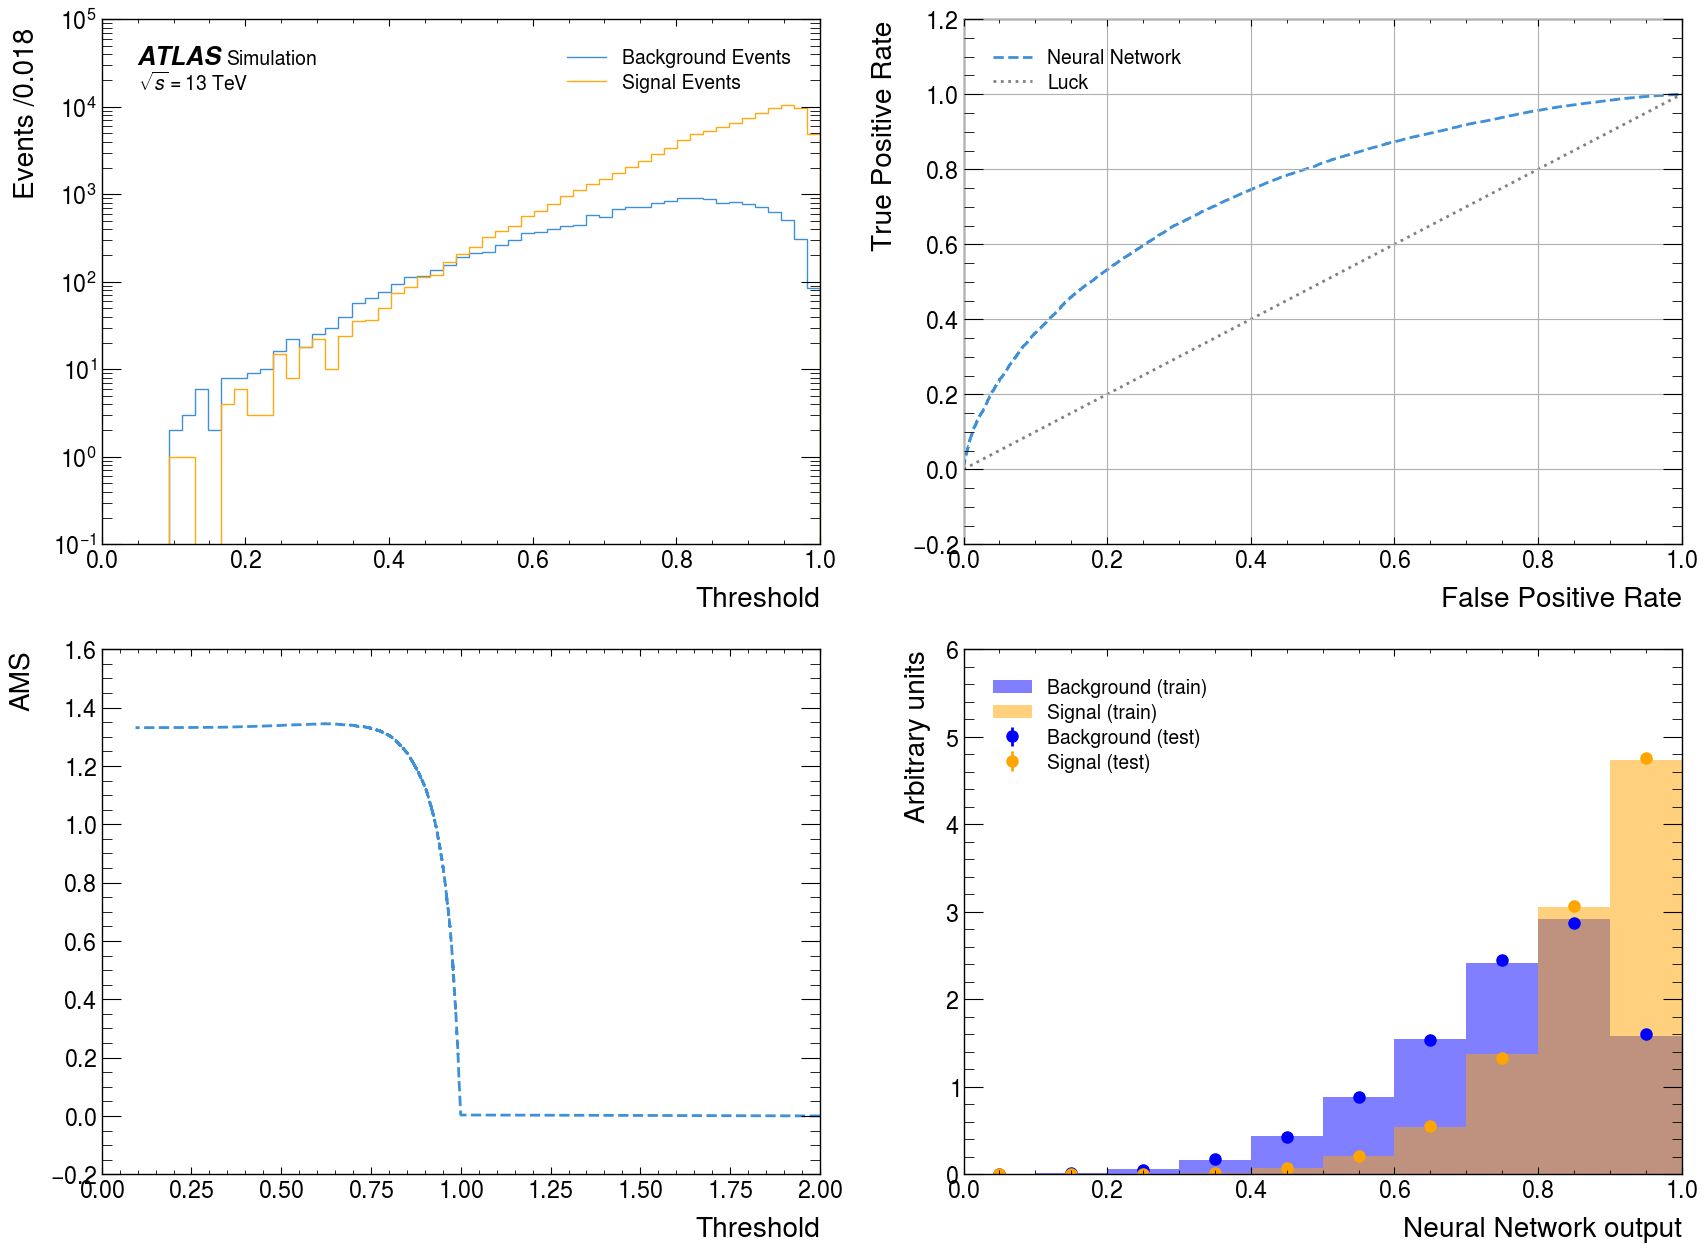

Accuracy Score: 0.8598
AUC Score: 0.740328
              precision    recall  f1-score   support

         0.0       0.55      0.07      0.12     16385
         1.0       0.87      0.99      0.92     99093

    accuracy                           0.86    115478
   macro avg       0.71      0.53      0.52    115478
weighted avg       0.82      0.86      0.81    115478

Confusion Matrix: 
[[ 1084 15301]
 [  891 98202]]
Precision: 0.8652
Recall: 0.991
F1-Score: 0.9238
Area under the Precision-Recall Curve: 0.8651


In [306]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
histogram([decisions_nn_reco[y_test_reco == 0],decisions_nn_reco[y_test_reco == 1]],50,['Background Events','Signal Events'],ax[0,0],ratio=False,x_units='')
ax[0,0].set_xlabel(r'Threshold')
ax[0,0].set_yscale('log')
ax[0,0].legend(loc='upper right')
ax[0,1].plot(fpr_nn_reco, tpr_nn_reco, linestyle="dashed", label="Neural Network")
ax[0,1].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0,1].set_xlabel("False Positive Rate")
ax[0,1].set_ylabel("True Positive Rate")
ax[0,1].grid()
ax[0,1].legend()
ax[1,0].plot(thresholds_nn_reco, ams_nn_reco, linestyle="dashed", label="Neural Network")
ax[1,0].set_xlabel(r'Threshold')
ax[1,0].set_ylabel(r'AMS')
compare_train_test(NN_clf_reco, X_train_scaled_reco, y_train_reco, X_test_scaled_reco, y_test_reco, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_reco, y_pred_NN_reco):.4g}")
print(f"AUC Score: {auc_score_reco:.6g}")
print(classification_report(y_test_reco,y_pred_NN_reco))
print(f"Confusion Matrix: \n{cm_reco}")
print(f"Precision: {precision_reco:.4g}")
print(f"Recall: {recall_reco:.4g}")
print(f"F1-Score: {f1_reco:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_reco:.4g}")

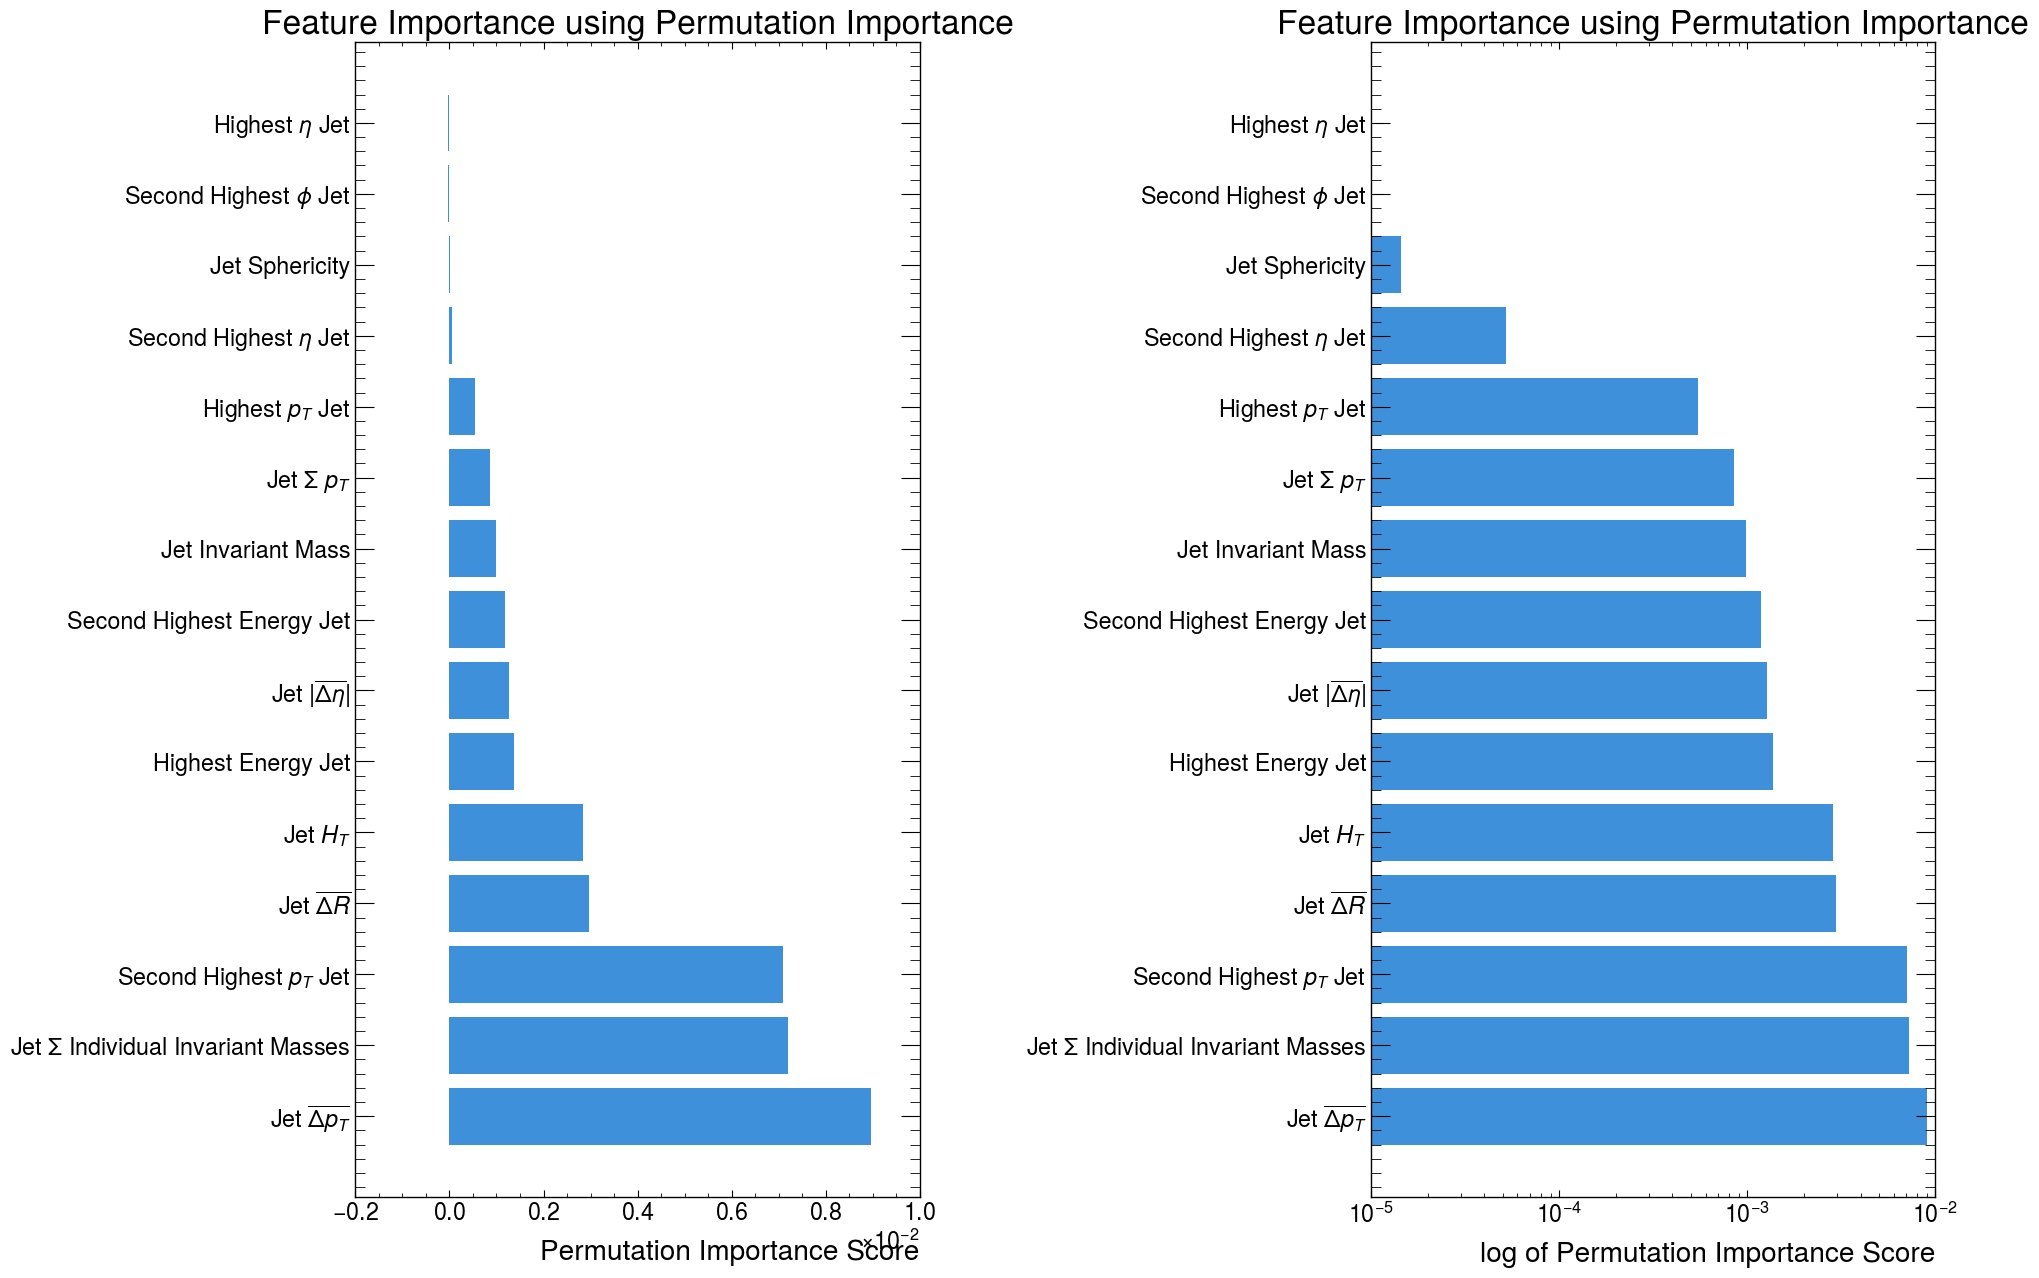

In [307]:
results_reco = permutation_importance(NN_clf_reco, X_test_tensor_reco, y_test_tensor_reco, n_repeats=30, random_state=42)
feature_names_reco = variable_names_reco_reduced

importance_scores_reco = results_reco.importances_mean

feature_importance_reco = sorted(zip(importance_scores_reco), reverse=True)

sorted_indices_reco = np.argsort(importance_scores_reco)[::-1]

sorted_importance_scores_reco = importance_scores_reco[sorted_indices_reco]
sorted_feature_names_reco = np.array(feature_names_reco)[sorted_indices_reco]
fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_reco, sorted_importance_scores_reco, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_reco, sorted_importance_scores_reco, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.8)
plt.show()

### Partonic

In [233]:
X_partonic = trans_partonic_data_reduced
y_partonic = labels_partonic
X_train_partonic, X_test_partonic, y_train_partonic, y_test_partonic = train_test_split(X_partonic, y_partonic, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_partonic)

X_train_scaled_partonic = scaler.transform(X_train_partonic)
X_test_scaled_partonic = scaler.transform(X_test_partonic)
X_scaled_partonic = scaler.transform(X_partonic)

In [234]:
epochs = 20  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_partonic[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
hidden_size3 = 64  # The number of nodes at the third hidden layer
dropout_rate = 0.2
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [235]:
X_train_tensor_partonic = torch.as_tensor(X_train_scaled_partonic, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_partonic = torch.as_tensor(y_train_partonic, dtype=torch.long)  # make tensor from y_train

X_train_var_partonic, y_train_var_partonic = Variable(X_train_tensor_partonic), Variable(y_train_tensor_partonic)  # make variables from tensors

X_valid_var_partonic, y_valid_var_partonic = (X_train_var_partonic[:10000],y_train_var_partonic[:10000],)  # get first 100 events for validation
X_train_nn_var_partonic, y_train_nn_var_partonic = (X_train_var_partonic[10000:],y_train_var_partonic[10000:],)  # get remaining events for training

train_data_partonic = Data.TensorDataset(X_train_nn_var_partonic, y_train_nn_var_partonic)  # create training dataset
valid_data_partonic = Data.TensorDataset(X_valid_var_partonic, y_valid_var_partonic)  # create validation dataset

train_loader_partonic = Data.DataLoader(dataset=train_data_partonic,batch_size=batch_size,shuffle=True,)
valid_loader_partonic = Data.DataLoader(dataset=valid_data_partonic,batch_size=batch_size,shuffle=True,)

In [236]:
NN_clf_partonic = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_partonic = torch.optim.Adam(NN_clf_partonic.parameters(), lr=learning_rate)
NN_clf_partonic.fit(train_loader_partonic,valid_loader_partonic,optimiser_partonic)

Epoch: 1, Train Loss: 0.151354
Validation Loss: 0.053786, Validation Accuracy: 0.980900
Epoch: 2, Train Loss: 0.045069
Validation Loss: 0.040347, Validation Accuracy: 0.985600
Epoch: 3, Train Loss: 0.032651
Validation Loss: 0.027254, Validation Accuracy: 0.990000
Epoch: 4, Train Loss: 0.027103
Validation Loss: 0.024139, Validation Accuracy: 0.991200
Epoch: 5, Train Loss: 0.022069
Validation Loss: 0.022212, Validation Accuracy: 0.992000
Epoch: 6, Train Loss: 0.020470
Validation Loss: 0.019021, Validation Accuracy: 0.992800
Epoch: 7, Train Loss: 0.018175
Validation Loss: 0.021770, Validation Accuracy: 0.992400
Epoch: 8, Train Loss: 0.017418
Validation Loss: 0.019289, Validation Accuracy: 0.992400
Epoch: 9, Train Loss: 0.016521
Validation Loss: 0.015962, Validation Accuracy: 0.995000
Epoch: 10, Train Loss: 0.015301
Validation Loss: 0.019120, Validation Accuracy: 0.992400
Epoch: 11, Train Loss: 0.014306
Validation Loss: 0.019467, Validation Accuracy: 0.992700
Epoch: 12, Train Loss: 0.01332

In [237]:
X_test_tensor_partonic = torch.as_tensor(X_test_scaled_partonic, dtype=torch.float)
y_test_tensor_partonic = torch.as_tensor(y_test_partonic, dtype=torch.long)

X_test_var_partonic, y_test_var_partonic = Variable(X_test_tensor_partonic), Variable(y_test_tensor_partonic)
out_partonic,prob_partonic = NN_clf_partonic(X_test_var_partonic)
y_pred_NN_partonic = (prob_partonic.cpu().detach().numpy().argmax(axis=1))

decisions_nn_partonic = (NN_clf_partonic(X_test_var_partonic)[1][:, 1].cpu().detach().numpy())

fpr_nn_partonic, tpr_nn_partonic, thresholds_nn_partonic = roc_curve(y_test_partonic, decisions_nn_partonic)

ams_nn_partonic = AMS(tpr_nn_partonic,fpr_nn_partonic,b_reg)

auc_score_partonic = roc_auc_score(y_test_partonic,decisions_nn_partonic)

cm_partonic = confusion_matrix(y_test_partonic, y_pred_NN_partonic)
precision_partonic = precision_score(y_test_partonic, y_pred_NN_partonic)
recall_partonic = recall_score(y_test_partonic, y_pred_NN_partonic)
f1_partonic = f1_score(y_test_partonic, y_pred_NN_partonic)
auc_pr_partonic = average_precision_score(y_test_partonic,y_pred_NN_partonic)

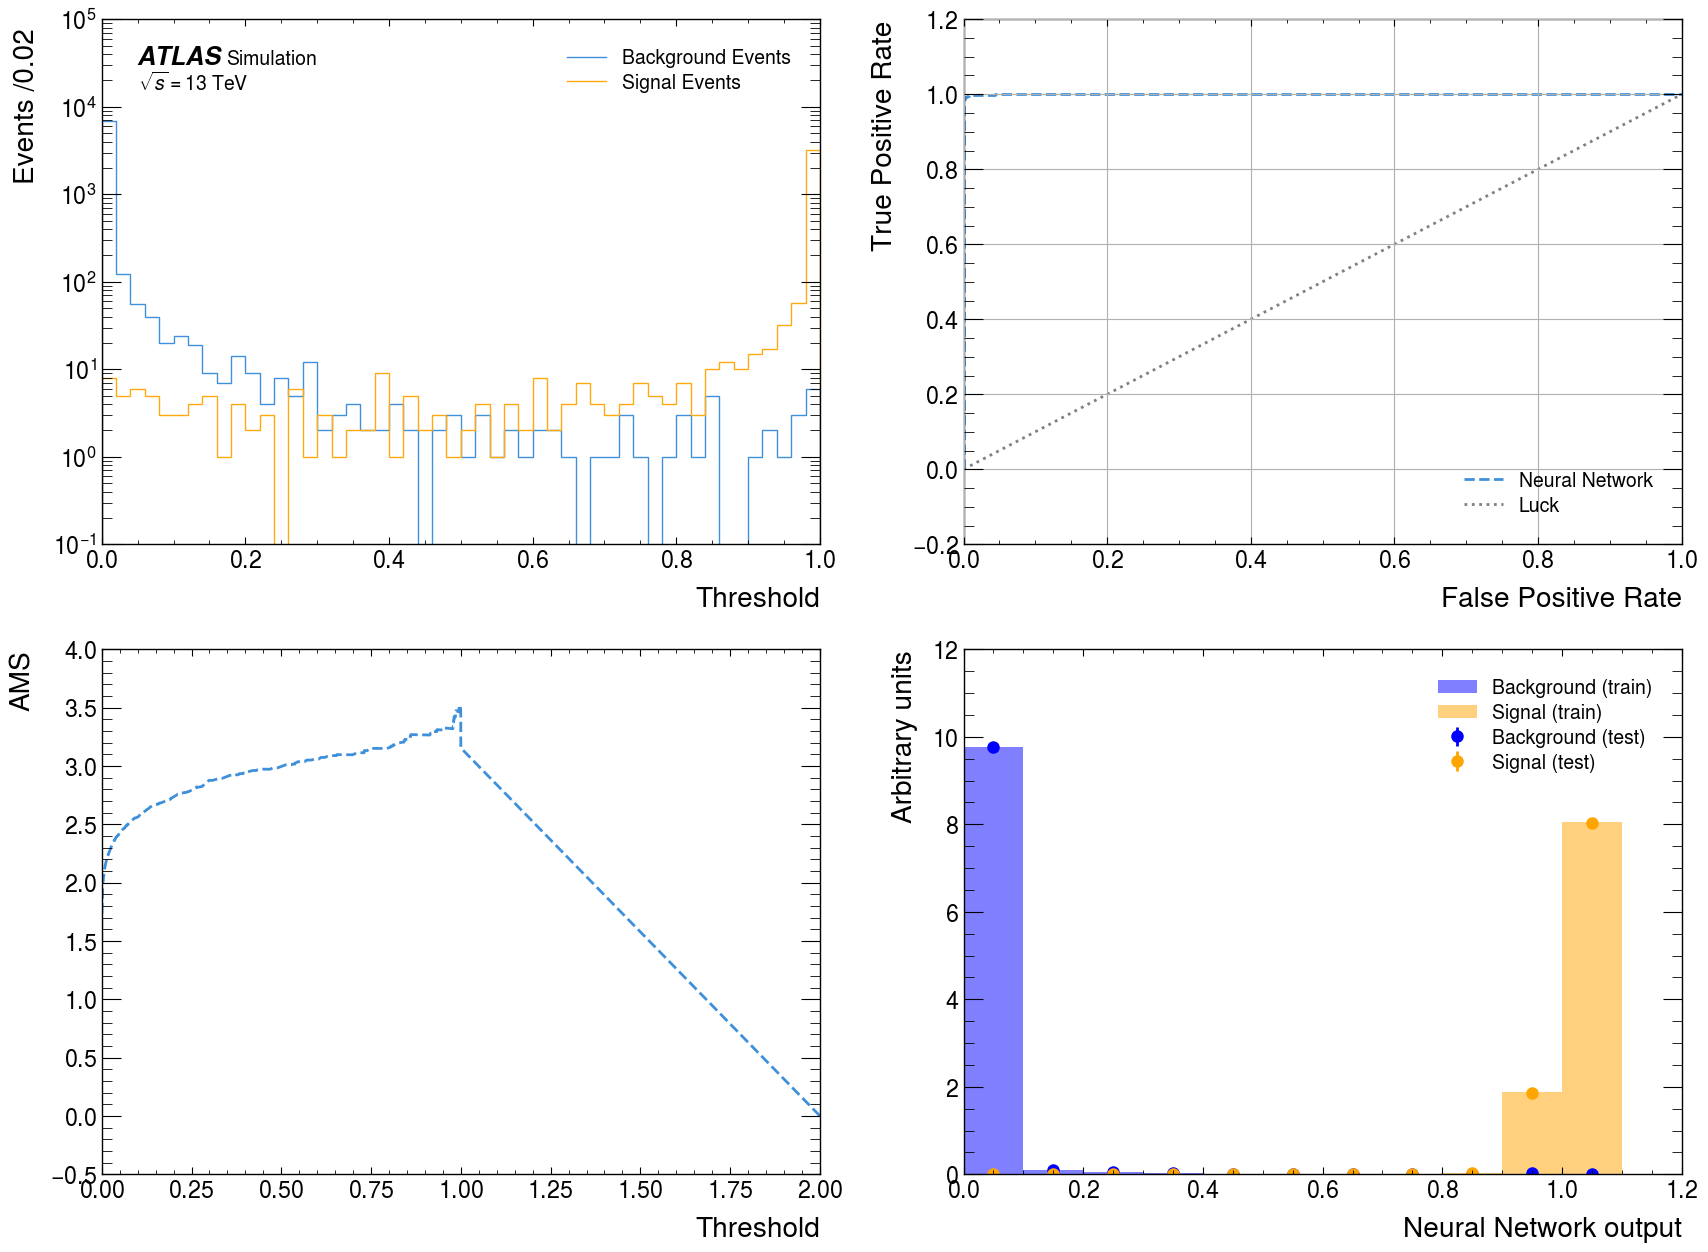

Accuracy Score: 0.994974
AUC Score: 0.999811
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      7256
         1.0       1.00      1.00      1.00     18015

    accuracy                           0.99     25271
   macro avg       0.99      0.99      0.99     25271
weighted avg       0.99      0.99      0.99     25271

Confusion Matrix: 
[[ 7214    42]
 [   85 17930]]
Precision: 0.9977
Recall: 0.9953
F1-Score: 0.9965
Area under the Precision-Recall Curve: 0.9963


In [244]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
histogram([decisions_nn_partonic[y_test_partonic == 0],decisions_nn_partonic[y_test_partonic == 1]],50,['Background Events','Signal Events'],ax[0,0],ratio=False,x_units='')
ax[0,0].set_xlabel(r'Threshold')
ax[0,0].set_yscale('log')
ax[0,1].plot(fpr_nn_partonic, tpr_nn_partonic, linestyle="dashed", label="Neural Network")
ax[0,1].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0,1].set_xlabel("False Positive Rate")
ax[0,1].set_ylabel("True Positive Rate")
ax[0,1].grid()
ax[0,1].legend()
ax[1,0].plot(thresholds_nn_partonic, ams_nn_partonic, linestyle="dashed", label="Neural Network")
ax[1,0].set_xlabel(r'Threshold')
ax[1,0].set_ylabel(r'AMS')
compare_train_test(NN_clf_partonic, X_train_scaled_partonic, y_train_partonic, X_test_scaled_partonic, y_test_partonic, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_partonic, y_pred_NN_partonic):.6g}")
print(f"AUC Score: {auc_score_partonic:.6g}")
print(classification_report(y_test_partonic,y_pred_NN_partonic))
print(f"Confusion Matrix: \n{cm_partonic}")
print(f"Precision: {precision_partonic:.4g}")
print(f"Recall: {recall_partonic:.4g}")
print(f"F1-Score: {f1_partonic:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_partonic:.4g}")

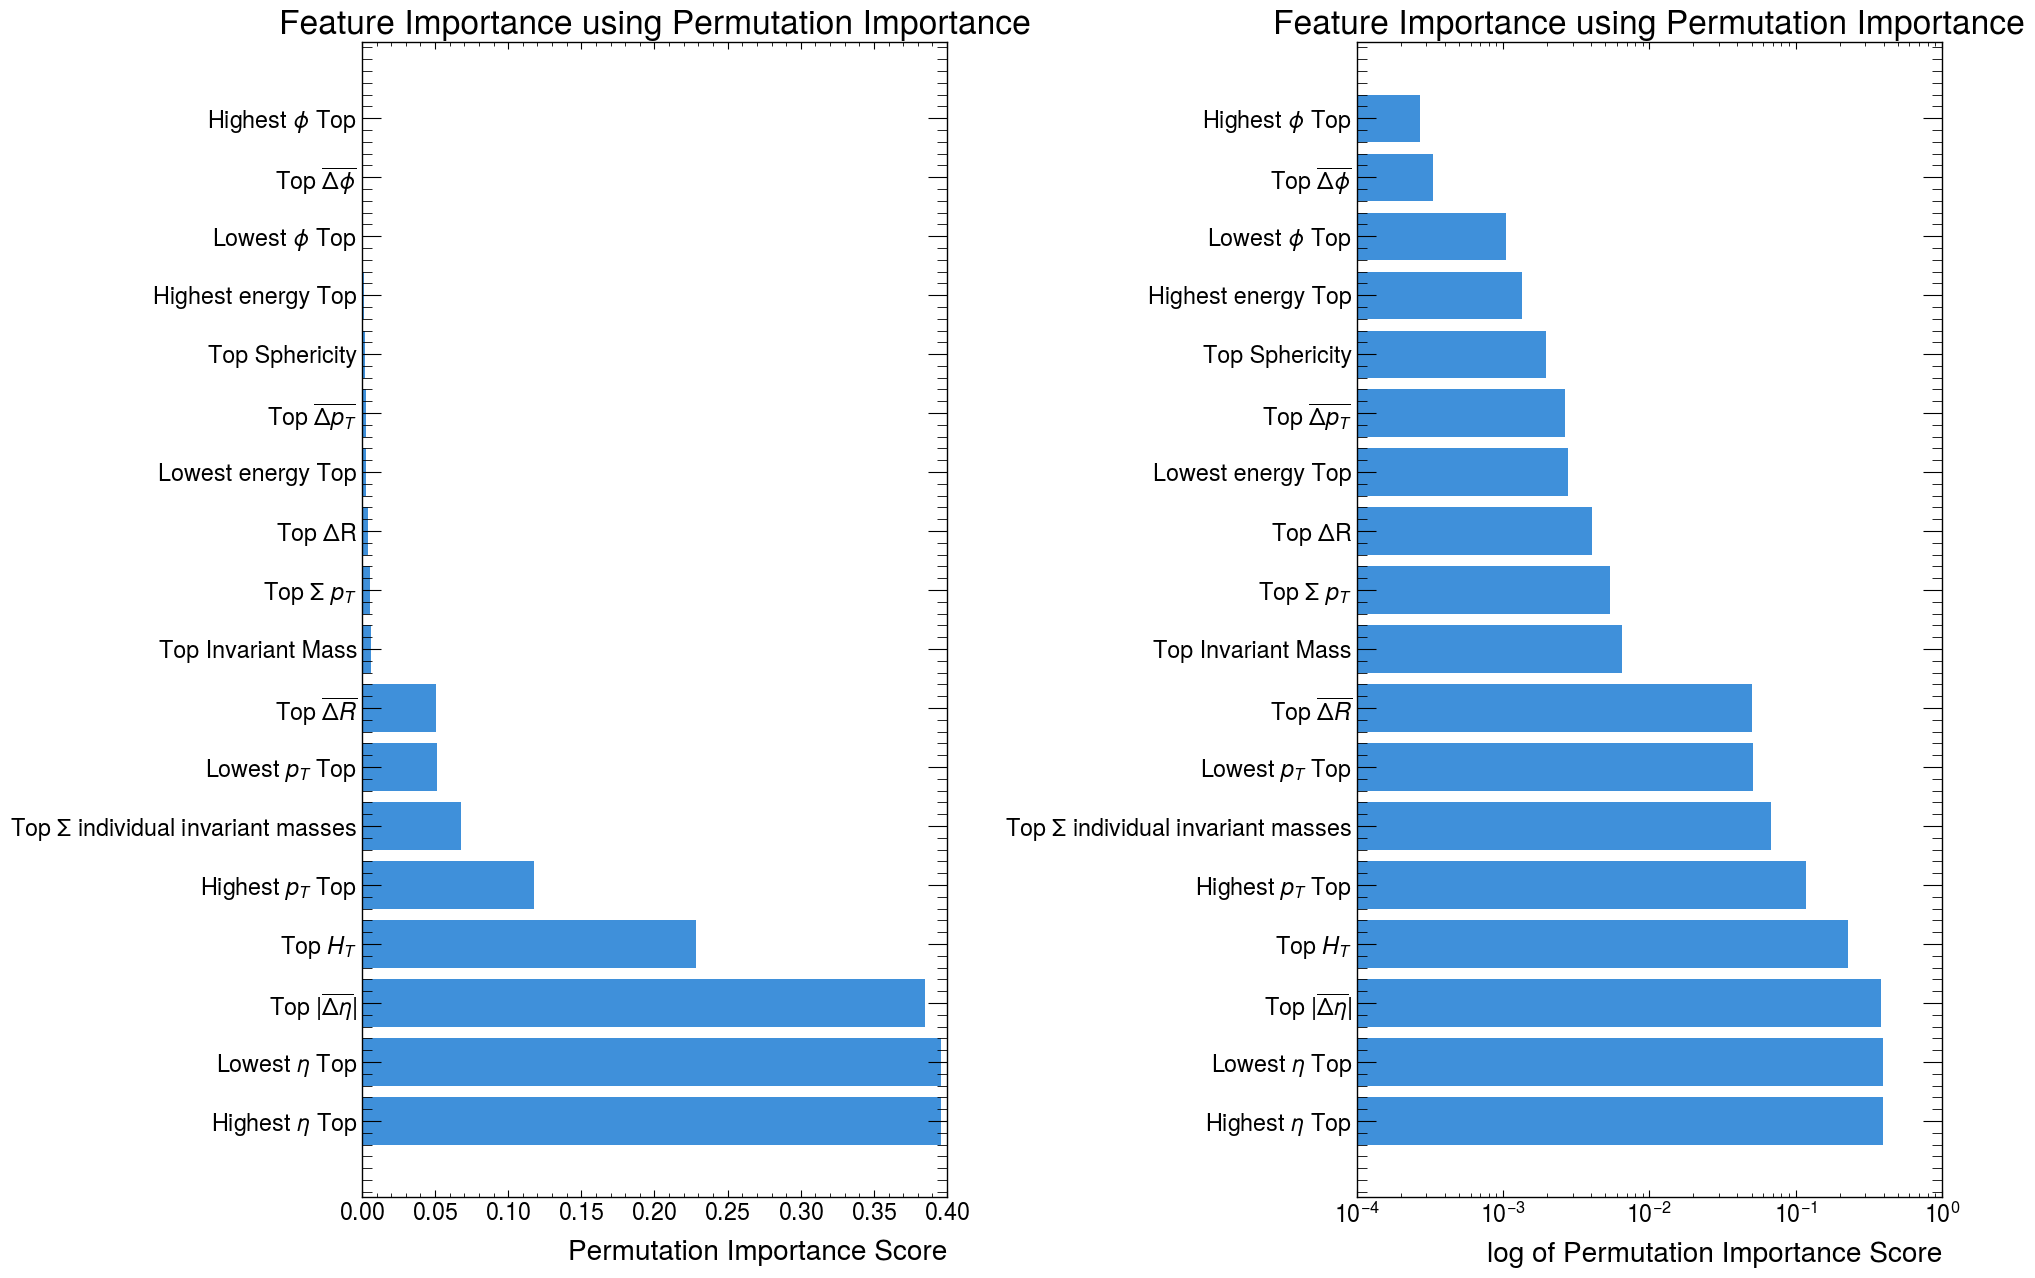

In [243]:
results_partonic = permutation_importance(NN_clf_partonic, X_test_tensor_partonic, y_test_tensor_partonic, n_repeats=30, random_state=42)
feature_names_partonic = variable_names_partonic_reduced

importance_scores_partonic = results_partonic.importances_mean

feature_importance_partonic = sorted(zip(importance_scores_partonic), reverse=True)

sorted_indices_partonic = np.argsort(importance_scores_partonic)[::-1]

sorted_importance_scores_partonic = importance_scores_partonic[sorted_indices_partonic]
sorted_feature_names_partonic = np.array(feature_names_partonic)[sorted_indices_partonic]

fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_partonic, sorted_importance_scores_partonic, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_partonic, sorted_importance_scores_partonic, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.7)
plt.show()

### Partonic with reco

In [219]:
X_partonic_reco = trans_partonic_reco_data_reduced
y_partonic_reco = labels_partonic_reco

X_train_partonic_reco, X_test_partonic_reco, y_train_partonic_reco, y_test_partonic_reco = train_test_split(X_partonic_reco, y_partonic_reco, test_size=0.33, random_state=seed_value)

scaler = StandardScaler()
scaler.fit(X_train_partonic_reco)

X_train_scaled_partonic_reco = scaler.transform(X_train_partonic_reco)
X_test_scaled_partonic_reco = scaler.transform(X_test_partonic_reco)
X_scaled_partonic_reco = scaler.transform(X_partonic_reco)

In [220]:
epochs = 20  # number of training epochs
batch_size = 20  # number of samples per batch
input_size = len(X_partonic_reco[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 32
hidden_size1 = 32  # The number of nodes at the first hidden layer
hidden_size2 = 32  # The number of nodes at the second hidden layer
hidden_size3 = 64  # The number of nodes at the third hidden layer
dropout_rate = 0.2
learning_rate = 0.001  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch

In [221]:
X_train_tensor_partonic_reco = torch.as_tensor(X_train_scaled_partonic_reco, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor_partonic_reco = torch.as_tensor(y_train_partonic_reco, dtype=torch.long)  # make tensor from y_train

X_train_var_partonic_reco, y_train_var_partonic_reco = Variable(X_train_tensor_partonic_reco), Variable(y_train_tensor_partonic_reco)  # make variables from tensors

X_valid_var_partonic_reco, y_valid_var_partonic_reco = (X_train_var_partonic_reco[:10000],y_train_var_partonic_reco[:10000],)  # get first 100 events for validation
X_train_nn_var_partonic_reco, y_train_nn_var_partonic_reco = (X_train_var_partonic_reco[10000:],y_train_var_partonic_reco[10000:],)  # get remaining events for training

train_data_partonic_reco = Data.TensorDataset(X_train_nn_var_partonic_reco, y_train_nn_var_partonic_reco)  # create training dataset
valid_data_partonic_reco = Data.TensorDataset(X_valid_var_partonic_reco, y_valid_var_partonic_reco)  # create validation dataset

train_loader_partonic_reco = Data.DataLoader(dataset=train_data_partonic_reco,batch_size=batch_size,shuffle=True,)
valid_loader_partonic_reco = Data.DataLoader(dataset=valid_data_partonic_reco,batch_size=batch_size,shuffle=True,)

In [222]:
NN_clf_partonic_reco = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimiser_partonic_reco = torch.optim.Adam(NN_clf_partonic_reco.parameters(), lr=learning_rate)
NN_clf_partonic_reco.fit(train_loader_partonic_reco,valid_loader_partonic_reco,optimiser_partonic_reco)

Epoch: 1, Train Loss: 0.102300
Validation Loss: 0.020365, Validation Accuracy: 0.993600
Epoch: 2, Train Loss: 0.018452
Validation Loss: 0.014534, Validation Accuracy: 0.995200
Epoch: 3, Train Loss: 0.012197
Validation Loss: 0.019173, Validation Accuracy: 0.993600
Epoch: 4, Train Loss: 0.009969
Validation Loss: 0.010063, Validation Accuracy: 0.996300
Epoch: 5, Train Loss: 0.008290
Validation Loss: 0.009164, Validation Accuracy: 0.996500
Epoch: 6, Train Loss: 0.007345
Validation Loss: 0.012389, Validation Accuracy: 0.996100
Epoch: 7, Train Loss: 0.007622
Validation Loss: 0.006153, Validation Accuracy: 0.997800
Epoch: 8, Train Loss: 0.005392
Validation Loss: 0.009119, Validation Accuracy: 0.997700
Epoch: 9, Train Loss: 0.004770
Validation Loss: 0.007868, Validation Accuracy: 0.997400
Epoch: 10, Train Loss: 0.004507
Validation Loss: 0.007678, Validation Accuracy: 0.997000
Epoch: 11, Train Loss: 0.003611
Validation Loss: 0.007927, Validation Accuracy: 0.997600
Epoch: 12, Train Loss: 0.00527

In [223]:
X_test_tensor_partonic_reco = torch.as_tensor(X_test_scaled_partonic_reco, dtype=torch.float)
y_test_tensor_partonic_reco = torch.as_tensor(y_test_partonic_reco, dtype=torch.long)

X_test_var_partonic_reco, y_test_var_partonic_reco = Variable(X_test_tensor_partonic_reco), Variable(y_test_tensor_partonic_reco)
out_partonic_reco,prob_partonic_reco = NN_clf_partonic_reco(X_test_var_partonic_reco)
y_pred_NN_partonic_reco = (prob_partonic_reco.cpu().detach().numpy().argmax(axis=1))

decisions_nn_partonic_reco = (NN_clf_partonic_reco(X_test_var_partonic_reco)[1][:, 1].cpu().detach().numpy())

fpr_nn_partonic_reco, tpr_nn_partonic_reco, thresholds_nn_partonic_reco = roc_curve(y_test_partonic_reco, decisions_nn_partonic_reco)

ams_nn_partonic_reco = AMS(tpr_nn_partonic_reco,fpr_nn_partonic_reco,b_reg)

auc_score_partonic_reco = roc_auc_score(y_test_partonic_reco,decisions_nn_partonic_reco)

cm_partonic_reco = confusion_matrix(y_test_partonic_reco, y_pred_NN_partonic_reco)
precision_partonic_reco = precision_score(y_test_partonic_reco, y_pred_NN_partonic_reco)
recall_partonic_reco = recall_score(y_test_partonic_reco, y_pred_NN_partonic_reco)
f1_partonic_reco = f1_score(y_test_partonic_reco, y_pred_NN_partonic_reco)
auc_pr_partonic_reco = average_precision_score(y_test_partonic_reco,y_pred_NN_partonic_reco)

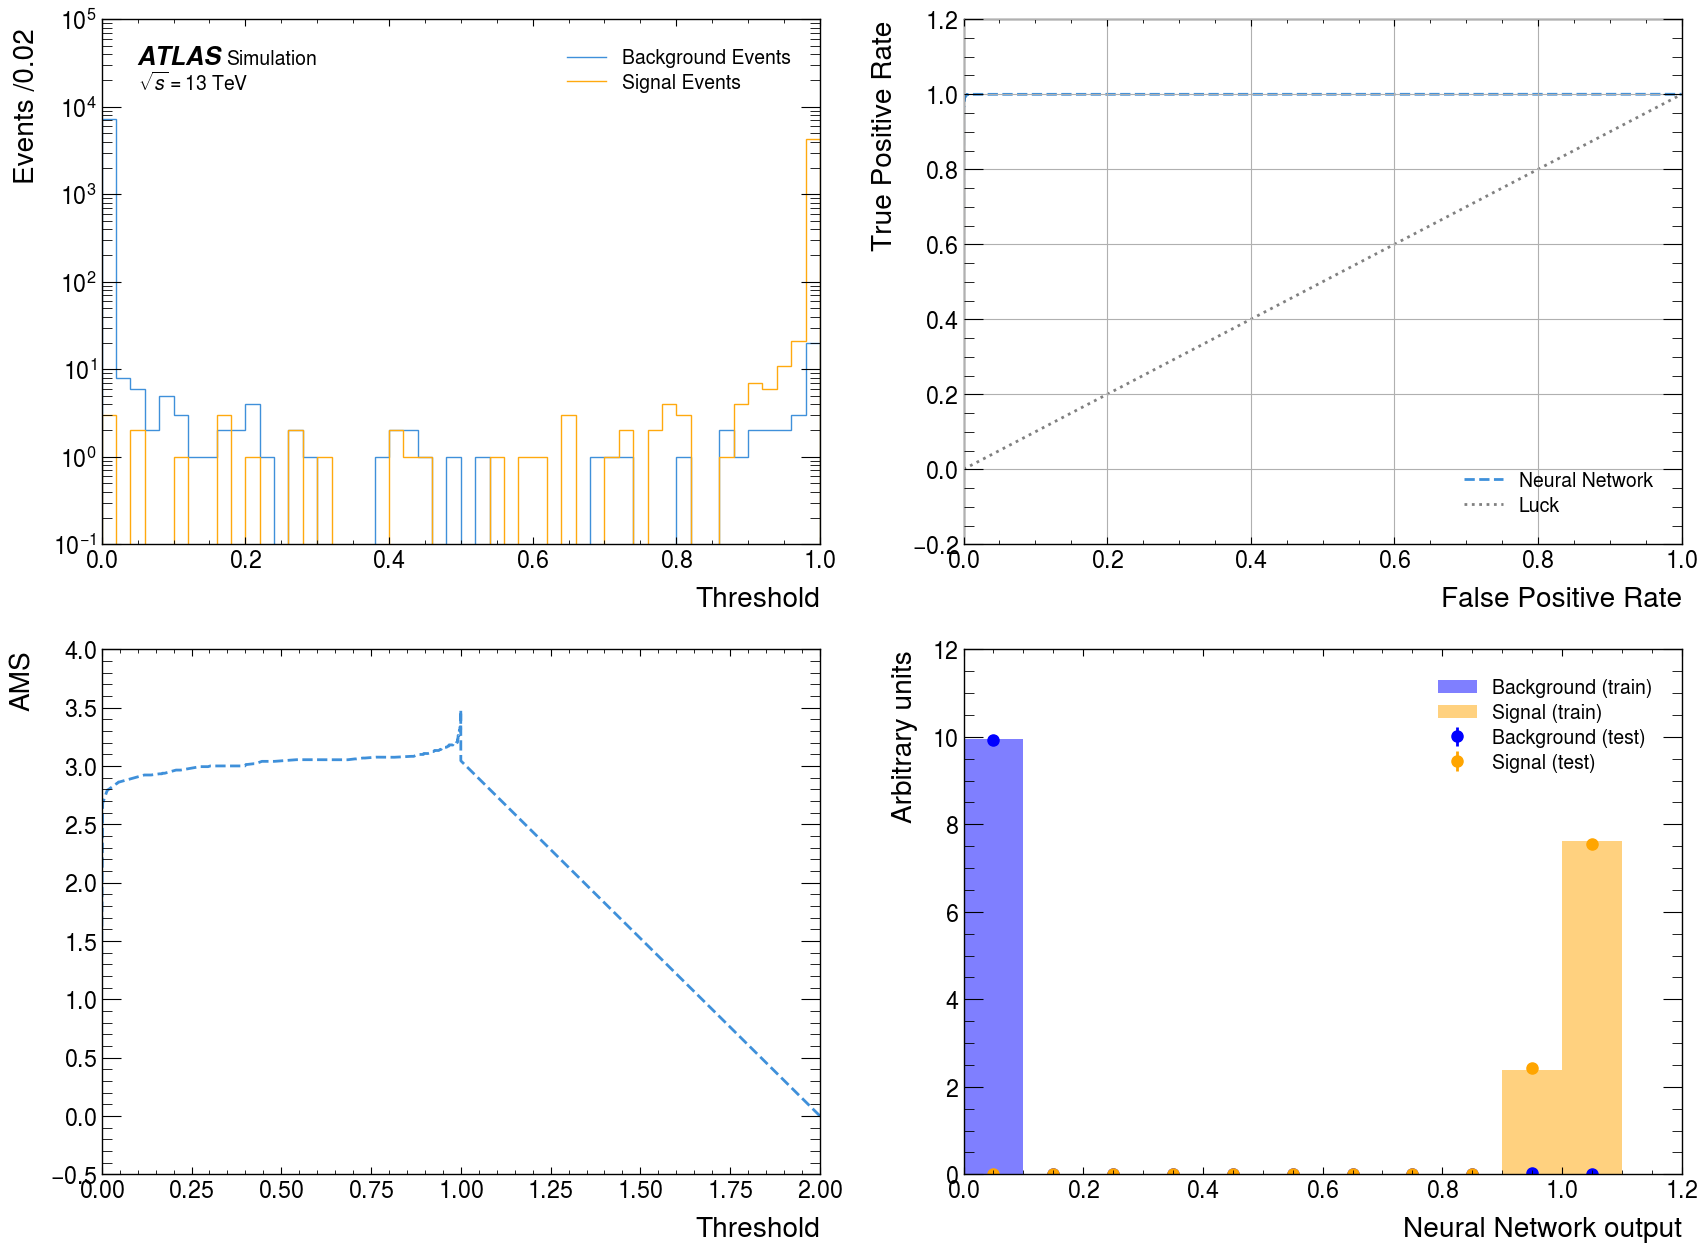

Accuracy Score: 0.9979
AUC Score: 0.999939
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      7329
         1.0       1.00      1.00      1.00     17941

    accuracy                           1.00     25270
   macro avg       1.00      1.00      1.00     25270
weighted avg       1.00      1.00      1.00     25270

Confusion Matrix: 
[[ 7292    37]
 [   17 17924]]
Precision: 0.9979
Recall: 0.9991
F1-Score: 0.9985
Area under the Precision-Recall Curve: 0.9977


In [224]:
fig, ax = plt.subplots(2,2, figsize=(20,15))
histogram([decisions_nn_partonic_reco[y_test_partonic_reco == 0],decisions_nn_partonic_reco[y_test_partonic_reco == 1]],50,['Background Events','Signal Events'],ax[0,0],ratio=False,x_units='')
ax[0,0].set_xlabel(r'Threshold')
ax[0,0].set_yscale('log')
ax[0,1].plot(fpr_nn_partonic_reco, tpr_nn_partonic_reco, linestyle="dashed", label="Neural Network")
ax[0,1].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")
ax[0,1].set_xlabel("False Positive Rate")
ax[0,1].set_ylabel("True Positive Rate")
ax[0,1].grid()
ax[0,1].legend()
ax[1,0].plot(thresholds_nn_partonic_reco, ams_nn_partonic_reco, linestyle="dashed", label="Neural Network")
ax[1,0].set_xlabel(r'Threshold')
ax[1,0].set_ylabel(r'AMS')
compare_train_test(NN_clf_partonic_reco, X_train_scaled_partonic_reco, y_train_partonic_reco, X_test_scaled_partonic_reco, y_test_partonic_reco, "Neural Network output")
plt.show()
print(f"Accuracy Score: {accuracy_score(y_test_partonic_reco, y_pred_NN_partonic_reco):.4g}")
print(f"AUC Score: {auc_score_partonic_reco:.6g}")
print(classification_report(y_test_partonic_reco,y_pred_NN_partonic_reco))
print(f"Confusion Matrix: \n{cm_partonic_reco}")
print(f"Precision: {precision_partonic_reco:.4g}")
print(f"Recall: {recall_partonic_reco:.4g}")
print(f"F1-Score: {f1_partonic_reco:.4g}")
print(f"Area under the Precision-Recall Curve: {auc_pr_partonic_reco:.4g}")

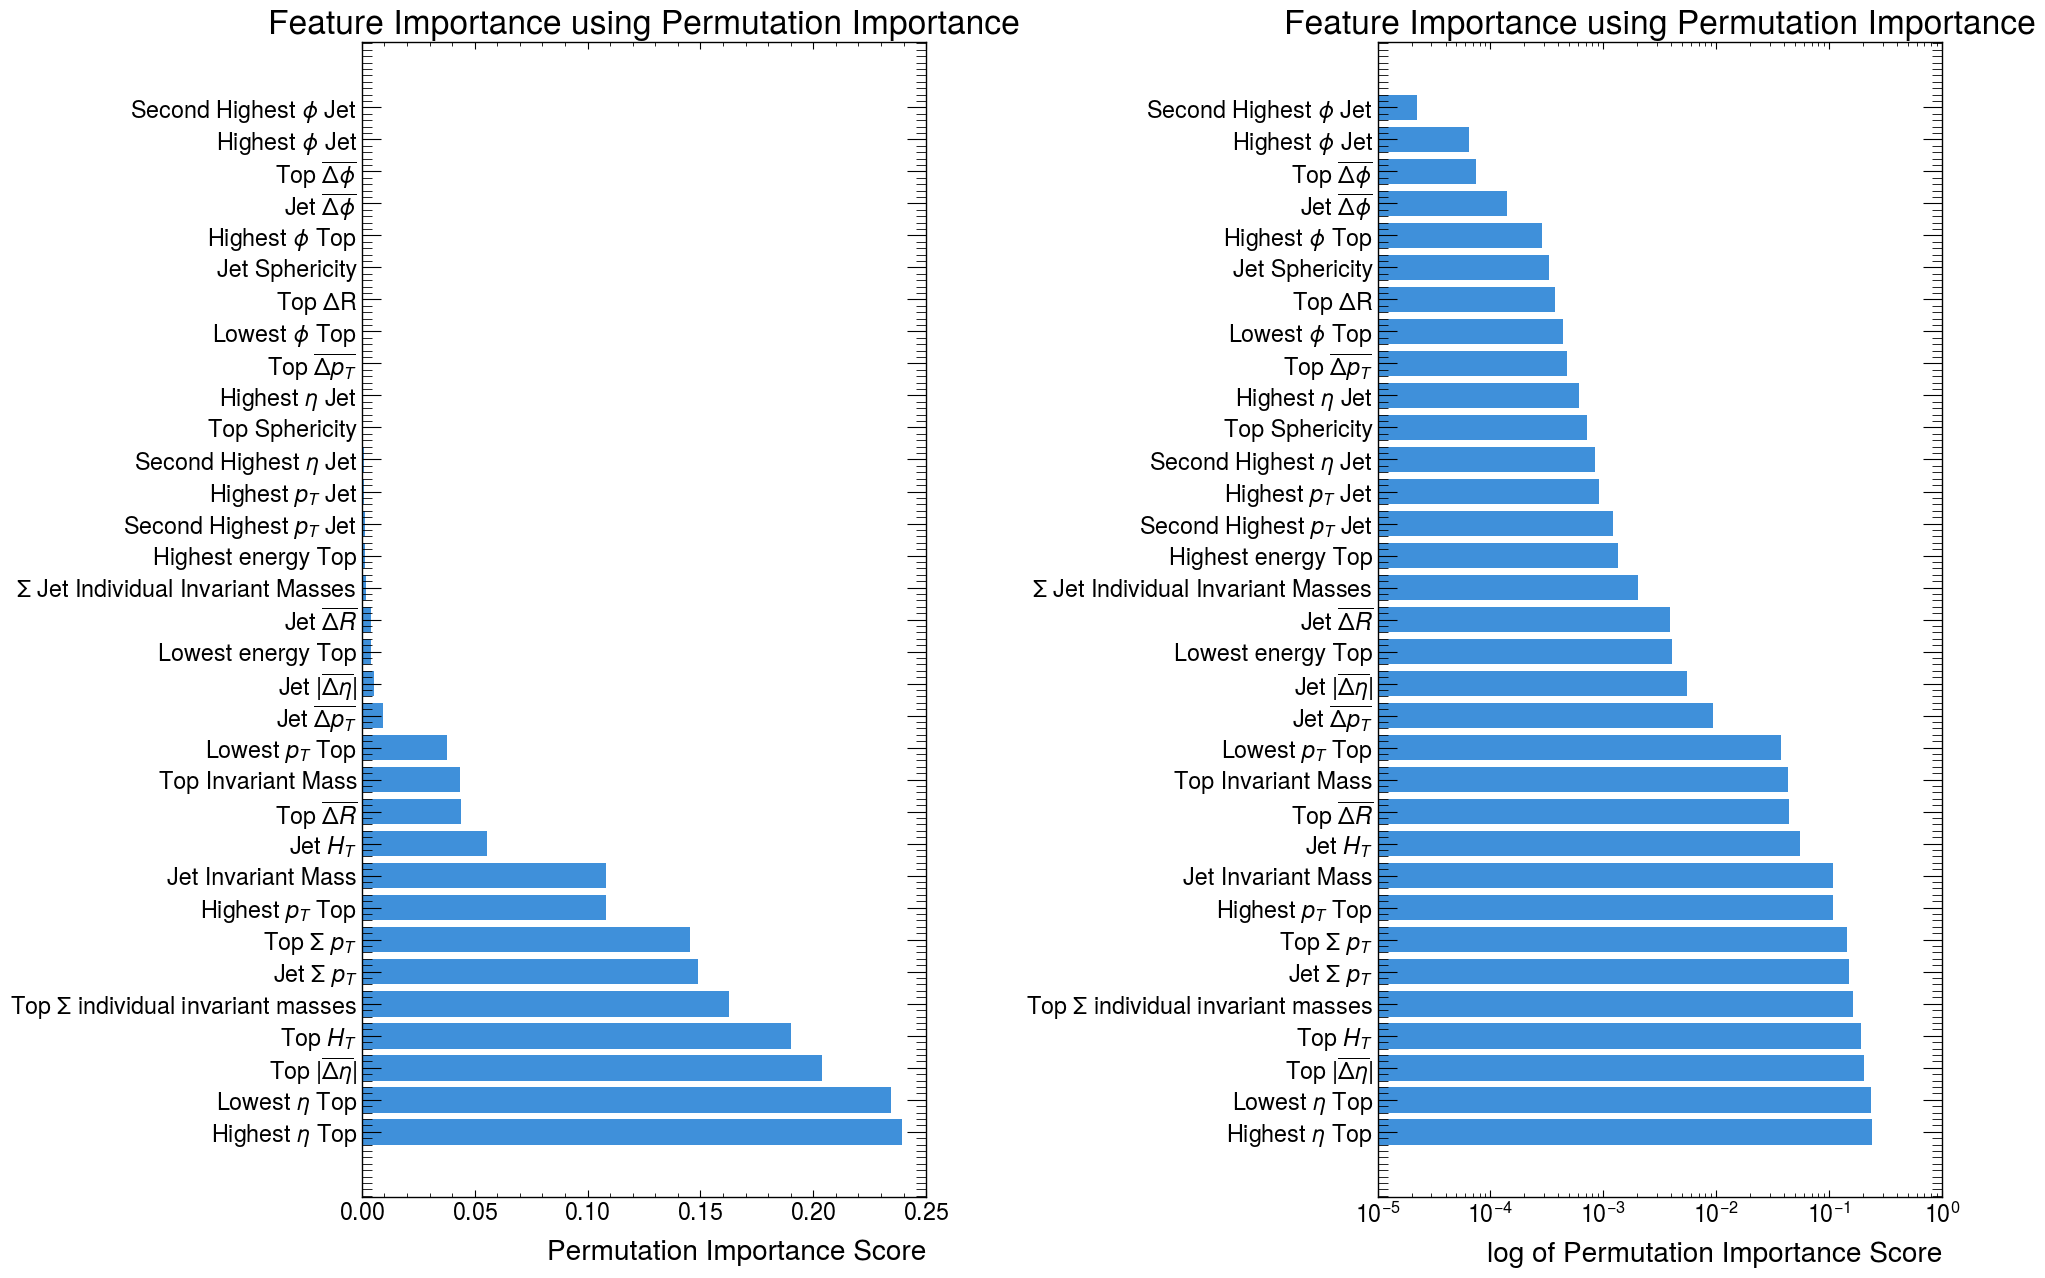

In [240]:
results_partonic_reco = permutation_importance(NN_clf_partonic_reco, X_test_tensor_partonic_reco, y_test_tensor_partonic_reco, n_repeats=30, random_state=42)
feature_names_partonic_reco = variable_names_partonic_reco_reduced

importance_scores_partonic_reco = results_partonic_reco.importances_mean

feature_importance_partonic_reco = sorted(zip(importance_scores_partonic_reco), reverse=True)

sorted_indices_partonic_reco = np.argsort(importance_scores_partonic_reco)[::-1]

sorted_importance_scores_partonic_reco = importance_scores_partonic_reco[sorted_indices_partonic_reco]
sorted_feature_names_partonic_reco = np.array(feature_names_partonic_reco)[sorted_indices_partonic_reco]

fig, ax = plt.subplots(1,2,figsize=(20, 15))
ax[0].barh(sorted_feature_names_partonic_reco, sorted_importance_scores_partonic_reco, align='center')
ax[0].set_xlabel('Permutation Importance Score')
ax[0].set_title('Feature Importance using Permutation Importance')

ax[1].barh(sorted_feature_names_partonic_reco, sorted_importance_scores_partonic_reco, align='center')
ax[1].set_xlabel('log of Permutation Importance Score')
ax[1].set_xscale('log')
ax[1].set_title('Feature Importance using Permutation Importance')
plt.subplots_adjust(wspace=0.8)
plt.show()